This notebook compares annotations using different GLLMs with codebooks based prompts of Boukes 2024, Jaidka 2022 and Naab 2025 on their respective datasets

In [8]:
import requests
import os
from dotenv import load_dotenv
load_dotenv("sjoerdAzure.env")  # Load environment variables from .env file
import time

import typing

from sklearn.metrics import cohen_kappa_score, classification_report
import krippendorff
import yaml

import pandas as pd

#import config
#import src
import tqdm
import json
import numpy as np
import logging

#import cltrier_lib as lib
import pyreadstat
import yaml
pd.set_option('display.max_colwidth', 100) 
#set up helper variables and functions:
#CFG = config.Config()

import matplotlib.pyplot as plt
import itertools
from matplotlib_venn import venn3
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency, fisher_exact
from scipy import stats
import statsmodels.api as sm
from statsmodels.genmod.bayes_mixed_glm import BinomialBayesMixedGLM
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns


In [2]:
# Define the mapping from concept to ground truth column
boukes_concepts_info = [
    ('Incivility', 'INCIVILITY_DUMMY'),
    ('Rationality', 'RATIONALITY_DUMMY'),
    ('Interactivity', 'INTERACTIVITY_DUMMY'),
    ('Liberal', 'LIBERAL_DUMMY'),
    ('Conservative', 'CONSERVATIVE_DUMMY'),
    ('Political Post', 'TopicRelevance')
]

# Helper: get ground truth column for a concept
def get_ground_truth_col(concept):
    for c, col in boukes_concepts_info:
        if c.lower() == concept.lower():
            return col
    raise ValueError(f"No ground truth column for concept: {concept}")

# Example usage: get_ground_truth_col('Incivility') -> 'INCIVILITY_DUMMY'

In [3]:
#load data:

# Jaida2024 data
jaidka = pd.read_parquet('data/jaidka2022/TwitterDeliberativePolitics2.parquet')
# Boukes
boukes = pd.read_parquet('data/publicsphere/publicsphere.cardiff_prompt_classify_anon.parquet')
boukesT = pd.read_csv('data/publicsphere/full_data.csv') # this includes the comments
#the Boukes2024 data is a subset of this, select YT part of Boukes in line with Boukes2024:
boukesTYT = boukesT[boukesT['Platform'] == 1]
#select Boukes paper data:
boukes2024 = boukes.loc[~boukes.topic.isna(),:]
#MH_clemm 2024
MHclemm = pd.read_parquet('data/MH_BClemm_data/Ideo_Val_GPT_USA_L33_70b.parquet')


In [4]:
# Define mapping for genre_paper
regular_news = [
    'CBS Evening News ', '60 Minutes', 'CBSEveningNews', 'MeetThePress', 'CBS Evening News', 'World News Tonight', 'ABC Nightline ',
    'NBC News', 'Face the Nation', 'World News Tonight With David Muir', 'NBCNews', 'ABCWorldNews', '60Minutes', 'FaceTheNation',
    'Meet The Press', 'ABC News', 'NightLine'
]
satire = [
    'colbertlateshow', 'Late Show with Colbert', 'Daily Show', 'Full Frontal with Samantha Bee ', 'Last week Tonight', 'Real Time with Bill Maher ',
    'FullFrontalSamB', 'Late Night with Seth Meyers ', 'Patriot Act with Hasan Minhaj', 'LastWeekTonight', 'patriotact', 'Full Frontal with Samantha Bee',
    'Patriot Act', 'TheDailyShow', 'LateNightSeth', 'Late Night with Seth Meyers', 'The Daily Show with Trevor Noah', 'Real Time with Bill Maher',
    'The Late Show with Stephen Colbert', 'RealTimers'
]
conservative_partisan_news = [
    'Hannity', 'Fox News', 'Hannity (FoxNews)', 'Tucker Carlson Tonight (FoxNews)', 'Tucker Carlson Tonight', 'TuckerCarlson'
]
liberal_partisan_news = [
    'The 11th Hour', 'Hardball with Chris Matthews (MSNBC)', 'Anderson Cooper 360 (CNN)', 'hardball', 'Anderson Cooper 360',
    'MSNBC', 'Hardball with Chris Matthews', 'AC360', '11thHour', 'CNN'
]
unknown = ['NewsHour']

# Function to map Genre to genre_paper
def map_genre_to_paper(genre):
    if genre in regular_news:
        return 'regular news'
    elif genre in satire:
        return 'satire'
    elif genre in conservative_partisan_news:
        return 'conservative partisan news'
    elif genre in liberal_partisan_news:
        return 'liberal partisan news'
    elif genre in unknown:
        return 'unknown'
    else:
        return 'other'

# Apply mapping to create genre_paper column
boukes['genre_paper'] = boukes['showName'].apply(map_genre_to_paper)
boukes2024['genre_paper'] = boukes2024['showName'].apply(map_genre_to_paper)

#make dummy for satire vs non satire
boukes2024['genre_paper_dum'] = boukes2024['genre_paper'].apply(lambda x: 1 if x == 'satire' else 0)


In [5]:
#define functions:

def get_labels(model_col):
    labels = {
        'concept': '',
        'model': '',
        'temperature': '',
        'seed': '',
        'run': '',
        'prompt_variant': ''
    }
    if 'rationality' in model_col:
        labels['concept'] = 'Rationality'
    if 'interactivity' in model_col or 'reciprocity' in model_col:
        labels['concept'] = 'Interactivity'
    if 'political_post' in model_col:
        labels['concept'] = 'Political Post'
    if '_con' in model_col:
        labels['concept'] = 'Conservative'
    if '_lib' in model_col:
        labels['concept'] = 'Liberal'
    if 'incivility' in model_col:
        labels['concept'] = 'Incivility'
    if 'gpt4o' in model_col:
        labels['model'] = 'GPT4o'
    if 'gpt4T' in model_col:
        labels['model'] = 'GPT4T'
    if 'L33_70b' in model_col:
        labels['model'] = 'Llama3.3:70b'
    if 'L31_8b' in model_col:
        labels['model'] = 'Llama3.1:8b'
    if 'Q25_72b' in model_col:
        labels['model'] = 'Qwen2.5:72b'
    if 'low' in model_col:
        labels['temperature'] = 'Low: 0.1'
    if 'zero' in model_col:
        labels['temperature'] = 'Zero: 0.0'
    if 'seed2' in model_col:
        labels['seed'] = 'Seed 2'
    if not 'seed2' in model_col:
        labels['seed'] = 'Seed 1'
    if 'run2' in model_col:
        labels['run'] = 'Run 2'
    if not 'run2' in model_col:
        labels['run'] = 'Run 1'
    if 'para1' in model_col:
        labels['prompt_variant'] = 'Para1'
    if 'para2' in model_col:
        labels['prompt_variant'] = 'Para2'
    if 'simpa1' in model_col:
        labels['prompt_variant'] = 'Simpa1'
    if 'jaidka' in model_col:
        labels['prompt_variant'] = 'Jaidka'
    if not ('para1' in model_col or 'para2' in model_col or 'simpa1' in model_col or 'jaidka' in model_col):
        labels['prompt_variant'] = 'Boukes'
    return labels

def get_col_by_labels(labelset=[], concept='', model='', temperature='', seed='', run='', prompt_variant=''):
    matches = []
    for col, labels in labelset.items():
        if (not concept or labels['concept'] == concept) and \
           (not model or labels['model'] == model) and \
           (not temperature or labels['temperature'] == temperature) and \
           (not seed or labels['seed'] == seed) and \
           (not run or labels['run'] == run) and \
           (not prompt_variant or labels['prompt_variant'] == prompt_variant):
            matches.append(col)
    return matches[0] if matches else None

def compute_accuracy(df, col1, col2):
    if col1 is None or col2 is None:
        return None
    return (df[col1] == df[col2]).mean()

#define functions:
def get_macro_f1_score(df, model_col, groundtruth_col):
    """
    Calculate the macro F1 score for a given model column against the ground truth.
    """
    y_true = df[groundtruth_col]
    y_pred = df[model_col]
    
    # Ensure both series are of the same length
    if len(y_true) != len(y_pred):
        raise ValueError("Length of true labels and predicted labels must be the same.")
    
    # Calculate classification report
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Return macro F1 score
    return report['macro avg']['f1-score']

In [6]:
#define column sets:
#make a selection of columns including the 5 prompts for 4 models for zero temperature within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_allprompts = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_allprompts = [col for col in model_columns_allprompts if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_allprompts = [col for col in model_columns_allprompts if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_allprompts = [col for col in model_columns_allprompts if col not in exclude_cols]

# Get all model columns that end with '_dum' and contain 'gpt4o', 'L33_70b', 'L31_8b', 'Q25_72b', or 'Q72b'
model_columns = [col for col in boukes.columns if col.endswith('_dum') and 'zero' in col and ('gpt4o' in col or 'gpt4T' in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns = [col for col in model_columns if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_zero_boukes = [col for col in model_columns if 'para' not in col and 'simpa' not in col and 'seed2' not in col and 'gpt4o_zero' not in col and 'jaidka' not in col]  #remove para and simpa columns, since these are not comparable with the gpt4o model

#make a selection of columns including the 5 prompts for 4 models for all temperatures within the Boukes data
#leave out GPT4T since we only have one prompt for that model, and it is not comparable with the other models
model_columns_alltemps = [col for col in boukes.columns if col.endswith('_dum') and ('gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col)]
model_columns_alltemps = [col for col in model_columns_alltemps if 'interactivity_acknowledgement_gpt4o_2_dum' not in col and 'gpt4T_zero' not in col and 'gpt4T_dum' not in col and 'political_conservative' not in col and 'political_liberal' not in col]  #remove the legacy non-system gpt4o columns, and the interactivity_acknowledgement_gpt4o_2_dum column
model_columns_alltemps = [col for col in model_columns_alltemps if 'seed2' not in col]
#exclude the civility columns ['civility_jaidka_Q25_72b_zero_dum', 'civility_jaidka_gpt4o_system_zero_dum', 'civility_jaidka_L31_8b_zero_dum', 'civility_jaidka_L33_70b_zero_dum']
exclude_cols = [
    'civility_jaidka_Q25_72b_zero_dum',
    'civility_jaidka_gpt4o_system_zero_dum',
    'civility_jaidka_L31_8b_zero_dum',
    'civility_jaidka_L33_70b_zero_dum'
]
model_columns_alltemps = [col for col in model_columns_alltemps if col not in exclude_cols]

#select all original ideological columns from the Boukes data, so not the dummy columns
ideological_columns = [col for col in boukes.columns if ('_dum' not in col and '_con' not in col and '_lib' not in col) and 'political_ideology_US' in col]
ideological_columns = [col for col in ideological_columns if 'seed2' not in col and 'run2' not in col]  #remove seed2 and run2 columns, since these are not comparable with the other columns
ideological_columns = [col for col in ideological_columns if 'gpt4o_system' in col in col or 'L33_70b' in col or 'L31_8b' in col or 'Q25_72b' in col] 

ideological_columns_zero = [col for col in ideological_columns if 'zero' in col]  

In [ ]:
#Evaluate downstream results of different models and prompts
#Hypotheses in Boukes 2024
# H1: Online political talk in the context of political satire is less interactive than online political talk in the context of regular news.
# Hypothesis 1 predicted that online political talk in the context of political satire would be less interactive than in the surrounding of regular news or partisan news. No significant differences regarding interactivity were, however, yielded between satire and regular news (p 1⁄4 .169, see Table 2). Also, the differences between satire and partisan news (both conservative and liberal) were insignificant; just as the differences between partisan and regular news (p > .454). H1 was therefore rejected; interactivity was stable across genres.
# H2: Online political talk in the context of political satire is less ideologically diverse than online political talk in the context of regular news.
#Whereas online political talk regarding satire (and regular news) was thus less opinionated overall, H2 predicted that the comments surrounding satire would also be less ideologically diverse. A cross-tabulation analysis (see Table 3) of all comments, Pearson χ2(12) 1⁄4 132.16, p < .001, showed that the proportion of liberal versus conservative comments was more balanced in the context of regular news (15.9% vs. 13.9%) than satire (18.6% vs. 9.7%). Moreover, the comments under partisan news also had a larger proportion of opposing opinions than satire (liberal news: 18.1% conservative comments; conservative news: 19.8% liberal comments). This aligns with H2.
#Multinomial logistic regression with standard errors clustered in the respective shows was used to test whether these ideological differences of comments were significant when also controlling for year, topic, and the other deliberative features (see Supplementary Appendix Table C1). No significant differences were observed for the comparison of satire vs. regular news for the likelihood of comments being either of liberal (p 1⁄4 .357) or conservative nature (p 1⁄4 .470) compared to neutral/mixed comments. Thus, H2 was not confirmed.
#Yet, comments in response to satire were less likely to express liberal opinions (p 1⁄4 .012) than comments made in the context of liberal partisan news. Comments in response to liberal partisan news, moreover, were also more likely to put forward a conservative opinion than satire (p 1⁄4 .004); the same was found for the comparison of satire and conservative partisan news (p < .001). Thus, partisan news was associated with more ideologically diverse comments; but this was not the case for satire, which combines partisan opinionatedness with humor.
# H3: Online political talk in the context of political satire is more rational than online political talk in the context of regular news.
#No significant differences were yielded when comparing the rationality of online political talk between satire, regular news, and partisan news (see Table 2). Hence, H3 was not confirmed. Interestingly, the comparison between regular news and liberal partisan news yielded a significant difference (comments in response to regular news are more rational; p 1⁄4 .015); all other comparisons were insignificant. Thus, a liberal bias in (partisan) news may be associated with less rationality, but not in the surrounding of the humorous satire genre.
# # H4: Online political talk in the context of political satire is less uncivil—in the form of (a) impoliteness and (b) intolerance—than online political talk in the context of regular news.
#since we don't classify impoliteness and intolerance, we will not evaluate H4


In [55]:
boukes2024['Time_comment_year'].value_counts()

Time_comment_year
2019    1212
2018     825
2017     227
2016     133
2015      43
2014      19
Name: count, dtype: int64

# Bivariate relation ideology and genre (Table 3 in Boukes, 2024)

In [26]:
#replicate Table 3. Cross-tabulations of comments’ ideological direction per genre
for col in ideological_columns_zero:
    labels = get_labels(col)
    concept = labels['concept']
    model = labels['model']
    prompt_variant = labels['prompt_variant']
    temperature = labels.get('temperature', 'N/A')
    
    # Create cross-tabulation
    crosstab = pd.crosstab(boukes[col], boukes2024['genre_paper'], margins=True, margins_name='Total') 
   
    # Save to dictionary
    all_crosstabs_dict = {}  # Initialize dictionary to store all crosstabs
    all_crosstabs_dict[f"{concept}_{model}_{prompt_variant}_{temperature}"] = crosstab

    print(f"\nCross-tabulation for {concept} ({model}, {prompt_variant}, Temp: {temperature}):")
    print(crosstab)




Cross-tabulation for  (GPT4o, Boukes, Temp: Zero: 0.0):
genre_paper                              conservative partisan news  \
political_ideology_US_gpt4o_system_zero                               
conservative                                                    164   
liberal                                                          81   
neutral                                                         233   
Total                                                           478   

genre_paper                              liberal partisan news  regular news  \
political_ideology_US_gpt4o_system_zero                                        
conservative                                                91           114   
liberal                                                    118           104   
neutral                                                    258           445   
Total                                                      467           663   

genre_paper                        

In [ ]:
#calculate the mean and standard deviation for the values in each cell of the cross-tabulation over the different models


In [48]:
boukes2024.genre_paper.value_counts()

genre_paper
satire                        851
regular news                  663
conservative partisan news    478
liberal partisan news         467
Name: count, dtype: int64

# mean crosstab across model annotations

In [27]:
# Function to collect crosstabs and calculate mean values per cell
def calculate_mean_crosstab_for_ideological_columns(data, columns, genre_column='genre_paper'):
    """
    Calculate mean crosstab values across multiple models/prompts for ideological columns.
    
    Parameters:
    - data: DataFrame containing the annotation data
    - columns: List of column names to process (e.g., ideological_columns_zero)
    - genre_column: Name of the column to cross-tabulate against (default: 'Genre')
    
    Returns:
    - mean_crosstab: DataFrame with mean values per cell
    - crosstab_details: Dictionary with individual crosstabs and metadata
    """
    
    # Store all crosstabs
    all_crosstabs = []
    crosstab_details = {}
    
    for col in columns:
        labels = get_labels(col)
        concept = labels['concept']
        model = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Create cross-tabulation
        crosstab = pd.crosstab(data[col], data[genre_column], margins=True, margins_name='Total')
        
        # Store the crosstab and its metadata
        crosstab_key = f"{concept}_{model}_{prompt_variant}_temp{temperature}"
        crosstab_details[crosstab_key] = {
            'crosstab': crosstab,
            'concept': concept,
            'model': model,
            'prompt_variant': prompt_variant,
            'temperature': temperature,
            'column': col
        }
        
        all_crosstabs.append(crosstab)
        
        print(f"\nCross-tabulation for {concept} ({model}, {prompt_variant}, Temp: {temperature}):")
        print(crosstab)
    
    # Calculate mean crosstab
    if all_crosstabs:
        # Sum all crosstabs
        mean_crosstab = all_crosstabs[0].copy()
        for crosstab in all_crosstabs[1:]:
            mean_crosstab = mean_crosstab.add(crosstab, fill_value=0)
        
        # Calculate mean by dividing by number of crosstabs
        mean_crosstab = mean_crosstab / len(all_crosstabs)
        
        print(f"\n{'='*60}")
        print(f"MEAN CROSSTAB ACROSS ALL {len(all_crosstabs)} MODELS/PROMPTS:")
        print(f"{'='*60}")
        print(mean_crosstab.round(2))
        
        return mean_crosstab, crosstab_details
    else:
        print("No crosstabs to calculate mean from.")
        return None, {}

# Execute the function for ideological columns
mean_crosstab_ideological, crosstab_details_ideological = calculate_mean_crosstab_for_ideological_columns(
    boukes2024, ideological_columns_zero, 'genre_paper'
)




Cross-tabulation for  (GPT4o, Boukes, Temp: Zero: 0.0):
genre_paper                              conservative partisan news  \
political_ideology_US_gpt4o_system_zero                               
conservative                                                    164   
liberal                                                          81   
neutral                                                         233   
Total                                                           478   

genre_paper                              liberal partisan news  regular news  \
political_ideology_US_gpt4o_system_zero                                        
conservative                                                91           114   
liberal                                                    118           104   
neutral                                                    258           445   
Total                                                      467           663   

genre_paper                        

In [30]:
# Function to calculate mean crosstab per cell position
def calculate_mean_crosstab_per_cell(crosstabs_dict):
    """
    Calculate mean values for each cell position across all crosstabs.
    
    Parameters:
    - crosstabs_dict: Dictionary of crosstabs from collect_all_crosstabs()
    
    Returns:
    - mean_crosstab: DataFrame with mean values per cell
    - cell_statistics: Dictionary with statistics per cell position
    """
    
    if not crosstabs_dict:
        print("No crosstabs provided.")
        return None, {}
    
    # Get all crosstabs - handle both formats (direct DataFrames or nested dicts)
    crosstabs = []
    for entry in crosstabs_dict.values():
        if isinstance(entry, dict) and 'crosstab' in entry:
            # Format: {'crosstab': DataFrame, 'concept': ..., etc.}
            crosstabs.append(entry['crosstab'])
        elif isinstance(entry, pd.DataFrame):
            # Format: DataFrame directly
            crosstabs.append(entry)
        else:
            print(f"Warning: Unknown format for crosstab entry: {type(entry)}")
            continue
    
    if not crosstabs:
        print("No valid crosstabs found.")
        return None, {}
    
    # Get common index and column names (should be same across all)
    common_index = crosstabs[0].index
    common_columns = crosstabs[0].columns
    
    # Initialize mean crosstab with zeros
    mean_crosstab = pd.DataFrame(0.0, index=common_index, columns=common_columns)
    
    # Initialize dictionary to store all values per cell for statistics
    cell_values = {}
    for idx in common_index:
        for col in common_columns:
            cell_values[(idx, col)] = []
    
    # Collect values for each cell position
    for crosstab in crosstabs:
        for idx in common_index:
            for col in common_columns:
                value = crosstab.loc[idx, col]
                mean_crosstab.loc[idx, col] += value
                cell_values[(idx, col)].append(value)
    
    # Calculate mean by dividing by number of crosstabs
    mean_crosstab = mean_crosstab / len(crosstabs)
    
    # Calculate statistics per cell
    cell_statistics = {}
    for cell_pos, values in cell_values.items():
        cell_statistics[cell_pos] = {
            'mean': np.mean(values),
            'std': np.std(values),
            'min': np.min(values),
            'max': np.max(values),
            'count': len(values)
        }
    
    print(f"Mean crosstab calculated from {len(crosstabs)} crosstabs:")
    print("="*50)
    print(mean_crosstab.round(2))
    
    return mean_crosstab, cell_statistics

# Calculate mean crosstab
mean_crosstab, cell_stats = calculate_mean_crosstab_per_cell(all_crosstabs_dict)

Mean crosstab calculated from 1 crosstabs:
genre_paper                                conservative partisan news  \
political_ideology_US_simpa1_L33_70b_zero                               
conservative                                                    185.0   
liberal                                                         138.0   
neutral                                                         155.0   
Total                                                           478.0   

genre_paper                                liberal partisan news  \
political_ideology_US_simpa1_L33_70b_zero                          
conservative                                               118.0   
liberal                                                    177.0   
neutral                                                    172.0   
Total                                                      467.0   

genre_paper                                regular news  satire   Total  
political_ideology_US_simpa1_L33_70

In [31]:
# Function to display detailed cell statistics
def display_cell_statistics(cell_stats, mean_crosstab):
    """
    Display detailed statistics for each cell position.
    """
    
    print("Detailed Statistics per Cell Position:")
    print("="*70)
    
    for (row_idx, col_idx), stats in cell_stats.items():
        print(f"\nCell [{row_idx}, {col_idx}]:")
        print(f"  Mean: {stats['mean']:.2f} ± {stats['std']:.2f}")
        print(f"  Range: [{stats['min']}, {stats['max']}]")
        print(f"  Count: {stats['count']}")

# Function to save crosstab results
def save_crosstab_analysis(mean_crosstab, cell_stats, all_crosstabs_dict, filename_prefix="crosstab_analysis"):
    """
    Save crosstab analysis results to files.
    """
    
    # Save mean crosstab
    mean_crosstab.to_csv(f"{filename_prefix}_mean.csv")
    
    # Create detailed statistics DataFrame
    stats_rows = []
    for (row_idx, col_idx), stats in cell_stats.items():
        stats_rows.append({
            'row': row_idx,
            'column': col_idx,
            'mean': stats['mean'],
            'std': stats['std'],
            'min': stats['min'],
            'max': stats['max'],
            'count': stats['count']
        })
    
    stats_df = pd.DataFrame(stats_rows)
    stats_df.to_csv(f"{filename_prefix}_cell_statistics.csv", index=False)
    
    # Save individual crosstabs
    with open(f"{filename_prefix}_individual_crosstabs.txt", 'w') as f:
        for key, entry in all_crosstabs_dict.items():
            f.write(f"\n{'='*60}\n")
            f.write(f"Crosstab: {key}\n")
            f.write(f"Concept: {entry['concept']}\n")
            f.write(f"Model: {entry['model']}\n")
            f.write(f"Prompt Variant: {entry['prompt_variant']}\n")
            f.write(f"Temperature: {entry['temperature']}\n")
            f.write(f"{'='*60}\n")
            f.write(str(entry['crosstab']))
            f.write("\n\n")
    
    print(f"Crosstab analysis saved:")
    print(f"  - {filename_prefix}_mean.csv")
    print(f"  - {filename_prefix}_cell_statistics.csv")
    print(f"  - {filename_prefix}_individual_crosstabs.txt")

# Display detailed statistics
display_cell_statistics(cell_stats, mean_crosstab)

# Save the analysis (uncomment to save files)
# save_crosstab_analysis(mean_crosstab, cell_stats, all_crosstabs_dict)

Detailed Statistics per Cell Position:

Cell [conservative, conservative partisan news]:
  Mean: 185.00 ± 0.00
  Range: [185, 185]
  Count: 1

Cell [conservative, liberal partisan news]:
  Mean: 118.00 ± 0.00
  Range: [118, 118]
  Count: 1

Cell [conservative, regular news]:
  Mean: 143.00 ± 0.00
  Range: [143, 143]
  Count: 1

Cell [conservative, satire]:
  Mean: 106.00 ± 0.00
  Range: [106, 106]
  Count: 1

Cell [conservative, Total]:
  Mean: 552.00 ± 0.00
  Range: [552, 552]
  Count: 1

Cell [liberal, conservative partisan news]:
  Mean: 138.00 ± 0.00
  Range: [138, 138]
  Count: 1

Cell [liberal, liberal partisan news]:
  Mean: 177.00 ± 0.00
  Range: [177, 177]
  Count: 1

Cell [liberal, regular news]:
  Mean: 162.00 ± 0.00
  Range: [162, 162]
  Count: 1

Cell [liberal, satire]:
  Mean: 295.00 ± 0.00
  Range: [295, 295]
  Count: 1

Cell [liberal, Total]:
  Mean: 772.00 ± 0.00
  Range: [772, 772]
  Count: 1

Cell [neutral, conservative partisan news]:
  Mean: 155.00 ± 0.00
  Range: 

## which models have a significant difference for which cell in the crosstab compared to the manual annotations

In [ ]:
# Statistical tests to compare two crosstabs


# McNemar test implementation (since it's not in scipy.stats)
def mcnemar_test(table):
    """
    Perform McNemar's test for paired nominal data.
    
    Parameters:
    - table: 2x2 contingency table as numpy array or list
    
    Returns:
    - statistic: McNemar test statistic
    - p_value: p-value of the test
    """
    table = np.array(table)
    if table.shape != (2, 2):
        raise ValueError("Table must be 2x2")
    
    # McNemar test statistic
    b, c = table[0, 1], table[1, 0]
    
    if b + c == 0:
        return 0.0, 1.0
    
    # With continuity correction
    statistic = (abs(b - c) - 1)**2 / (b + c)
    
    # p-value from chi-square distribution with 1 df
    from scipy.stats import chi2
    p_value = 1 - chi2.cdf(statistic, df=1)
    
    return statistic, p_value

def compare_crosstabs_statistical_tests(manual_data, model_data, genre_column='genre_paper'):
    """
    Perform statistical tests to compare two crosstabs.
    
    Parameters:
    - manual_data: DataFrame column with manual annotations (binary)
    - model_data: DataFrame column with model annotations (binary)
    - genre_column: Column name for genre categories
    
    Returns:
    - Dictionary with test results and DataFrames
    """
    
    # Create crosstabs
    manual_crosstab = pd.crosstab(manual_data, boukes[genre_column])
    model_crosstab = pd.crosstab(model_data, boukes[genre_column])
    
    print("Manual Crosstab:")
    print(manual_crosstab)
    print("\nModel Crosstab:")
    print(model_crosstab)
    
    results = {}
    test_results_list = []  # List to store all test results for DataFrame
    
    
    # 2. McNemar's test (for paired data if same observations)
    try:
        # Create contingency table for paired comparisons
        paired_table = pd.crosstab(manual_data, model_data)
        print(f"\n2. Paired comparison table:")
        print(paired_table)
        
        if paired_table.shape == (2, 2):
            mcnemar_stat, mcnemar_p = mcnemar_test(paired_table.values)
            results['mcnemar'] = {
                'statistic': mcnemar_stat,
                'p_value': mcnemar_p,
                'interpretation': 'Tests if manual and model annotations differ significantly (paired data)'
            }
            
            # Add to DataFrame list
            test_results_list.append({
                'test_type': 'mcnemar',
                'genre': 'all',
                'statistic': mcnemar_stat,
                'p_value': mcnemar_p,
                'dof': 1,
                'manual_positive': None,
                'manual_total': None,
                'model_positive': None,
                'model_total': None,
                'manual_proportion': None,
                'model_proportion': None,
                'odds_ratio': None,
                'interpretation': 'Paired comparison test'
            })
            
            print(f"\n   McNemar test:")
            print(f"   Chi2 = {mcnemar_stat:.4f}, p = {mcnemar_p:.4f}")
            print(f"   Interpretation: {'Significant difference' if mcnemar_p < 0.05 else 'No significant difference'} between manual and model")
    except Exception as e:
        print(f"McNemar test failed: {e}")
    
    # 3. Fisher's exact test for each genre category
    print(f"\n3. Fisher's exact tests by genre:")
    fisher_results = {}
    
    for genre in manual_crosstab.columns:
        # Create 2x2 table for this genre
        manual_pos = manual_crosstab.loc[1, genre] if 1 in manual_crosstab.index else 0
        manual_neg = manual_crosstab.loc[0, genre] if 0 in manual_crosstab.index else 0
        model_pos = model_crosstab.loc[1, genre] if 1 in model_crosstab.index else 0
        model_neg = model_crosstab.loc[0, genre] if 0 in model_crosstab.index else 0
        
        manual_total = manual_pos + manual_neg
        model_total = model_pos + model_neg
        manual_prop = manual_pos / manual_total if manual_total > 0 else 0
        model_prop = model_pos / model_total if model_total > 0 else 0
        
        table_2x2 = [[manual_pos, manual_neg], [model_pos, model_neg]]
        
        try:
            odds_ratio, fisher_p = fisher_exact(table_2x2)
            fisher_results[genre] = {
                'odds_ratio': odds_ratio,
                'p_value': fisher_p,
                'manual_positive': manual_pos,
                'manual_total': manual_total,
                'model_positive': model_pos,
                'model_total': model_total
            }
            
            # Add to DataFrame list
            test_results_list.append({
                'test_type': 'fisher_exact',
                'genre': genre,
                'statistic': None,
                'p_value': fisher_p,
                'dof': None,
                'manual_positive': manual_pos,
                'manual_total': manual_total,
                'model_positive': model_pos,
                'model_total': model_total,
                'manual_proportion': manual_prop,
                'model_proportion': model_prop,
                'odds_ratio': odds_ratio,
                'interpretation': f'Fisher exact test for {genre}'
            })
            
            print(f"   {genre}: OR = {odds_ratio:.3f}, p = {fisher_p:.4f}")
        except Exception as e:
            print(f"   {genre}: Fisher test failed - {e}")
    
    results['fisher_by_genre'] = fisher_results
    
    # 4. Proportion tests for each genre
    print(f"\n4. Proportion tests by genre:")
    from statsmodels.stats.proportion import proportions_ztest
    
    prop_results = {}
    for genre in manual_crosstab.columns:
        manual_pos = manual_crosstab.loc[1, genre] if 1 in manual_crosstab.index else 0
        manual_total = manual_crosstab.loc[:, genre].sum()
        model_pos = model_crosstab.loc[1, genre] if 1 in model_crosstab.index else 0
        model_total = model_crosstab.loc[:, genre].sum()
        
        manual_prop = manual_pos / manual_total if manual_total > 0 else 0
        model_prop = model_pos / model_total if model_total > 0 else 0
        
        if manual_total > 0 and model_total > 0:
            try:
                z_stat, prop_p = proportions_ztest([manual_pos, model_pos], [manual_total, model_total])
                prop_results[genre] = {
                    'z_statistic': z_stat,
                    'p_value': prop_p,
                    'manual_prop': manual_prop,
                    'model_prop': model_prop
                }
                
                # Add to DataFrame list
                test_results_list.append({
                    'test_type': 'proportion_test',
                    'genre': genre,
                    'statistic': z_stat,
                    'p_value': prop_p,
                    'dof': None,
                    'manual_positive': manual_pos,
                    'manual_total': manual_total,
                    'model_positive': model_pos,
                    'model_total': model_total,
                    'manual_proportion': manual_prop,
                    'model_proportion': model_prop,
                    'odds_ratio': None,
                    'interpretation': f'Proportion test for {genre}'
                })
                
                print(f"   {genre}: Z = {z_stat:.3f}, p = {prop_p:.4f} (Manual: {manual_prop:.3f}, Model: {model_prop:.3f})")
            except Exception as e:
                print(f"   {genre}: Proportion test failed - {e}")
    
    results['proportion_tests'] = prop_results
    
    # Create DataFrame from results
    results_df = pd.DataFrame(test_results_list)
    results['results_dataframe'] = results_df
    
    print(f"\n" + "="*60)
    print("SUMMARY RESULTS DATAFRAME:")
    print("="*60)
    print(results_df)
    
    return results



In [ ]:
# Function to create comprehensive summary table for all models and concepts
def create_comprehensive_crosstab_summary(boukes_data, concepts_info, model_columns, genre_column='genre_paper'):
    """
    Create a single summary table with crosstab test results for all models across all concepts.
    
    Parameters:
    - boukes_data: DataFrame containing the data
    - concepts_info: List of tuples (concept_name, manual_column)
    - model_columns: List of model column names
    - genre_column: Column name for genre categories
    
    Returns:
    - DataFrame with comprehensive results
    """
    
    all_results = []
    
    print("Running comprehensive crosstab analysis...")
    print("="*60)
    
    for concept, manual_col in concepts_info:
        print(f"\nProcessing concept: {concept}")
        print("-" * 40)
        
        # Get model columns for this concept
        concept_model_cols = [col for col in model_columns if get_labels(col)['concept'] == concept]
        
        if not concept_model_cols:
            print(f"No model columns found for concept: {concept}")
            continue
            
        if manual_col not in boukes_data.columns:
            print(f"Manual column {manual_col} not found for concept: {concept}")
            continue
        
        for model_col in concept_model_cols:
            try:
                # Get model information
                labels = get_labels(model_col)
                model_name = labels['model']
                prompt_variant = labels['prompt_variant']
                temperature = labels.get('temperature', 'N/A')
                
                print(f"  Testing model: {model_name} ({prompt_variant}, Temp: {temperature})")
                
                # Run the statistical tests
                test_results = compare_crosstabs_statistical_tests(
                    manual_data=boukes_data[manual_col],
                    model_data=boukes_data[model_col],
                    genre_column=genre_column
                )
                
                # Get the results DataFrame
                results_df = test_results['results_dataframe'].copy()
                
                # Add concept and model information to each row
                results_df['concept'] = concept
                results_df['manual_column'] = manual_col
                results_df['model_column'] = model_col
                results_df['model_name'] = model_name
                results_df['prompt_variant'] = prompt_variant
                results_df['temperature'] = temperature
                
                # Add to the comprehensive list
                all_results.append(results_df)
                
            except Exception as e:
                print(f"    Error processing {model_col}: {e}")
                continue
    
    # Combine all results into a single DataFrame
    if all_results:
        comprehensive_df = pd.concat(all_results, ignore_index=True)
        
        # Format p-values: round to 3 decimal places and show "< 0.001" for very small values
        def format_p_value(p_val):
            if pd.isna(p_val):
                return p_val
            elif p_val < 0.001:
                return "< 0.001"
            else:
                return round(p_val, 3)
        
        # Create a formatted p-value column
        comprehensive_df['p_value_formatted'] = comprehensive_df['p_value'].apply(format_p_value)
        
        # Round other numerical columns to 3 decimal places
        numerical_cols = ['statistic', 'manual_proportion', 'model_proportion', 'odds_ratio']
        for col in numerical_cols:
            if col in comprehensive_df.columns:
                comprehensive_df[col] = comprehensive_df[col].round(3)
        
        # Reorder columns for better readability
        column_order = [
            'concept', 'model_name', 'prompt_variant', 'temperature', 'model_column',
            'test_type', 'genre', 'statistic', 'p_value_formatted', 'p_value', 'dof',
            'manual_positive', 'manual_total', 'manual_proportion',
            'model_positive', 'model_total', 'model_proportion',
            'odds_ratio', 'interpretation', 'manual_column'
        ]
        
        # Only include columns that exist in the DataFrame
        available_columns = [col for col in column_order if col in comprehensive_df.columns]
        comprehensive_df = comprehensive_df[available_columns]
        
        print(f"\n" + "="*80)
        print("COMPREHENSIVE CROSSTAB ANALYSIS SUMMARY")
        print("="*80)
        print(f"Total test results: {len(comprehensive_df)}")
        print(f"Concepts analyzed: {len(comprehensive_df['concept'].unique())}")
        print(f"Models analyzed: {len(comprehensive_df['model_column'].unique())}")
        print(f"Test types: {comprehensive_df['test_type'].unique()}")
        
        # Summary statistics
        print(f"\nSignificant results (p < 0.05): {len(comprehensive_df[comprehensive_df['p_value'] < 0.05])}")
        print(f"Highly significant results (p < 0.01): {len(comprehensive_df[comprehensive_df['p_value'] < 0.01])}")
        print(f"Very highly significant results (p < 0.001): {len(comprehensive_df[comprehensive_df['p_value'] < 0.001])}")
        
        # Display some example formatted p-values
        print(f"\nExample p-value formatting:")
        sample_p_values = comprehensive_df[['test_type', 'genre', 'p_value', 'p_value_formatted']].head(10)
        print(sample_p_values)
        
        return comprehensive_df
    else:
        print("No results were generated.")
        return pd.DataFrame()



# Run comprehensive analysis
print("Starting comprehensive crosstab analysis...")
comprehensive_results = create_comprehensive_crosstab_summary(
    boukes_data=boukes2024,
    concepts_info=boukes_concepts_info,
    model_columns=model_columns_alltemps,
    genre_column='genre_paper'
)

print("\nComprehensive crosstab analysis completed.")
print(f"Total results: {len(comprehensive_results)}")
print(comprehensive_results.head())

Starting comprehensive crosstab analysis...
Running comprehensive crosstab analysis...

Processing concept: Incivility
----------------------------------------
  Testing model: GPT4o (Boukes, Temp: Zero: 0.0)
Manual Crosstab:
genre_paper       conservative partisan news  liberal partisan news  \
INCIVILITY_DUMMY                                                      
0                                        184                    181   
1                                        294                    286   

genre_paper       regular news  satire  
INCIVILITY_DUMMY                        
0                          318     452  
1                          345     399  

Model Crosstab:
genre_paper                               conservative partisan news  \
incivility_simple2_gpt4o_system_zero_dum                               
0                                                                263   
1                                                                215   

genre_paper        

In [ ]:
comprehensive_results

# How does the prevalence in the Boukes2024 data of each concept differ between human and each model annotation

In [48]:
# Function to evaluate model significance vs manual annotations and output results in a DataFrame
from statsmodels.stats.proportion import proportions_ztest

# Function to perform a proportion test
def perform_proportion_test(group1, group2):
    """
    Perform a proportion test for two binary groups.
    
    Parameters:
    - group1: Binary data for the first group
    - group2: Binary data for the second group
    
    Returns:
    - z_stat: Z-statistic
    - p_value: P-value
    """
    count = [group1.sum(), group2.sum()]  # Number of successes in each group
    nobs = [len(group1), len(group2)]    # Number of observations in each group
    
    z_stat, p_value = proportions_ztest(count, nobs)
    return z_stat, p_value


# Function to calculate standard error for binary variables
def calculate_binary_se(mean, n):
    """
    Calculate standard error for binary variables based on mean and sample size.
    
    Parameters:
    - mean: Mean value of the binary variable
    - n: Sample size
    
    Returns:
    - se: Standard error
    """
    return ((mean * (1 - mean)) / n) ** 0.5





def evaluate_model_significance_vs_manual_df(dataset, manual_annotations, model_set):
    """
    Evaluate which models have significant differences compared to manual annotations.
    
    Parameters:
    - dataset: DataFrame containing the dataset with model annotations
    - manual_annotations: Column name for manual annotations
    - model_set: List of model columns to evaluate
    
    Returns:
    - results_df: DataFrame with significance results for each model column
    """
    
    results = []
    
    for col in model_set:
        labels = get_labels(col)
        concept = labels['concept']
        model = labels['model']
        prompt_variant = labels['prompt_variant']
        temperature = labels.get('temperature', 'N/A')
        
        # Get model annotations
        model_annotations = dataset[col].dropna()
        manual_annotations_data = dataset[manual_annotations].dropna()
                        
        # Perform proportion test
        if len(model_annotations) > 0 and len(manual_annotations_data) > 0:
            z_stat, p_value = perform_proportion_test(model_annotations, manual_annotations_data)
            
            # Calculate means and standard errors
            model_mean = model_annotations.mean()
            manual_mean = manual_annotations_data.mean()
            model_se = calculate_binary_se(model_mean, len(model_annotations))
            manual_se = calculate_binary_se(manual_mean, len(manual_annotations_data))
            
            results.append({
                'column': col,
                'concept': concept,
                'model': model,
                'prompt_variant': prompt_variant,
                'temperature': temperature,
                'model_mean': model_mean,
                'model_std': model_se,  
                'manual_mean': manual_mean,
                'manual_std': manual_se,  
                'z_stat': z_stat,
                'p_value': p_value,
                'n': len(model_annotations)
            })
            print(f"{model} ({prompt_variant}, Temp: {temperature}): z-stat={z_stat:.3f}, p-value={p_value:.3f}")
        else:
            print(f"No data available for {model} ({prompt_variant}, Temp: {temperature}) or manual annotations.")
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    return results_df

# Evaluate models for each concept and output results in a DataFrame
all_results = []
for concept, gt_col in boukes_concepts_info:
    print(f"\nEvaluating models for concept: {concept}")
    # Get model columns for this concept
    model_set = [col for col in model_columns_alltemps if get_labels(col)['concept'] == concept]
    print(f"{concept}: {model_set}")

    if not model_set:
        print(f"No model columns found for concept: {concept}")
        continue
    
    # Check if manual annotations exist for this concept
    if gt_col not in boukes2024.columns:
        print(f"No manual annotations found for concept: {concept}")
        continue  
    
    try:
        significance_results_df = evaluate_model_significance_vs_manual_df(
            dataset=boukes2024,
            manual_annotations=gt_col,
            model_set=model_set
        )
        all_results.append(significance_results_df)
    except Exception as e:
        print(f"Error evaluating models for {concept}: {e}")
        continue

# Combine all results into a single DataFrame
final_results_df = pd.concat(all_results, ignore_index=True)
print("\nFinal Results:")
print(final_results_df)


Evaluating models for concept: Incivility
Incivility: ['incivility_simple2_gpt4o_system_zero_dum', 'incivility_simple2_L33_70b_low_dum', 'incivility_jaidka_L33_70b_low_dum', 'incivility_para1_L33_70b_low_dum', 'incivility_para2_L33_70b_low_dum', 'incivility_simpa1_L33_70b_low_dum', 'incivility_jaidka_L31_8b_low_dum', 'incivility_para1_L31_8b_low_dum', 'incivility_para2_L31_8b_low_dum', 'incivility_simpa1_L31_8b_low_dum', 'incivility_simple2_Q25_72b_zero_dum', 'incivility_jaidka_Q25_72b_zero_dum', 'incivility_para1_Q25_72b_zero_dum', 'incivility_para2_Q25_72b_zero_dum', 'incivility_simpa1_Q25_72b_zero_dum', 'incivility_simple2_L33_70b_zero_dum', 'incivility_simple2_L31_8b_zero_dum', 'incivility_simple2_Q25_72b_low_dum', 'incivility_jaidka_gpt4o_system_zero_dum', 'incivility_para1_gpt4o_system_zero_dum', 'incivility_para2_gpt4o_system_zero_dum', 'incivility_simpa1_gpt4o_system_zero_dum', 'incivility_jaidka_L31_8b_zero_dum', 'incivility_para1_L31_8b_zero_dum', 'incivility_para2_L31_8b_ze

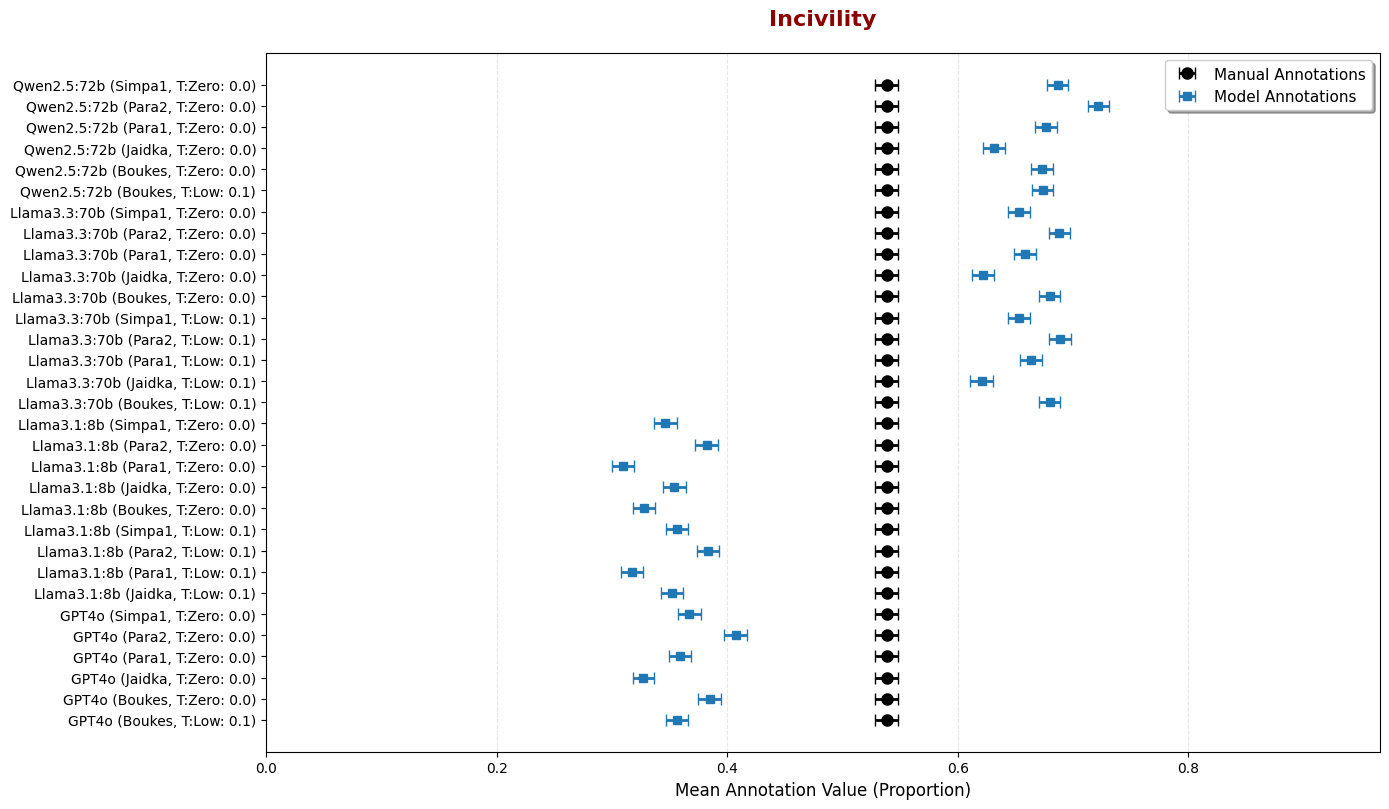

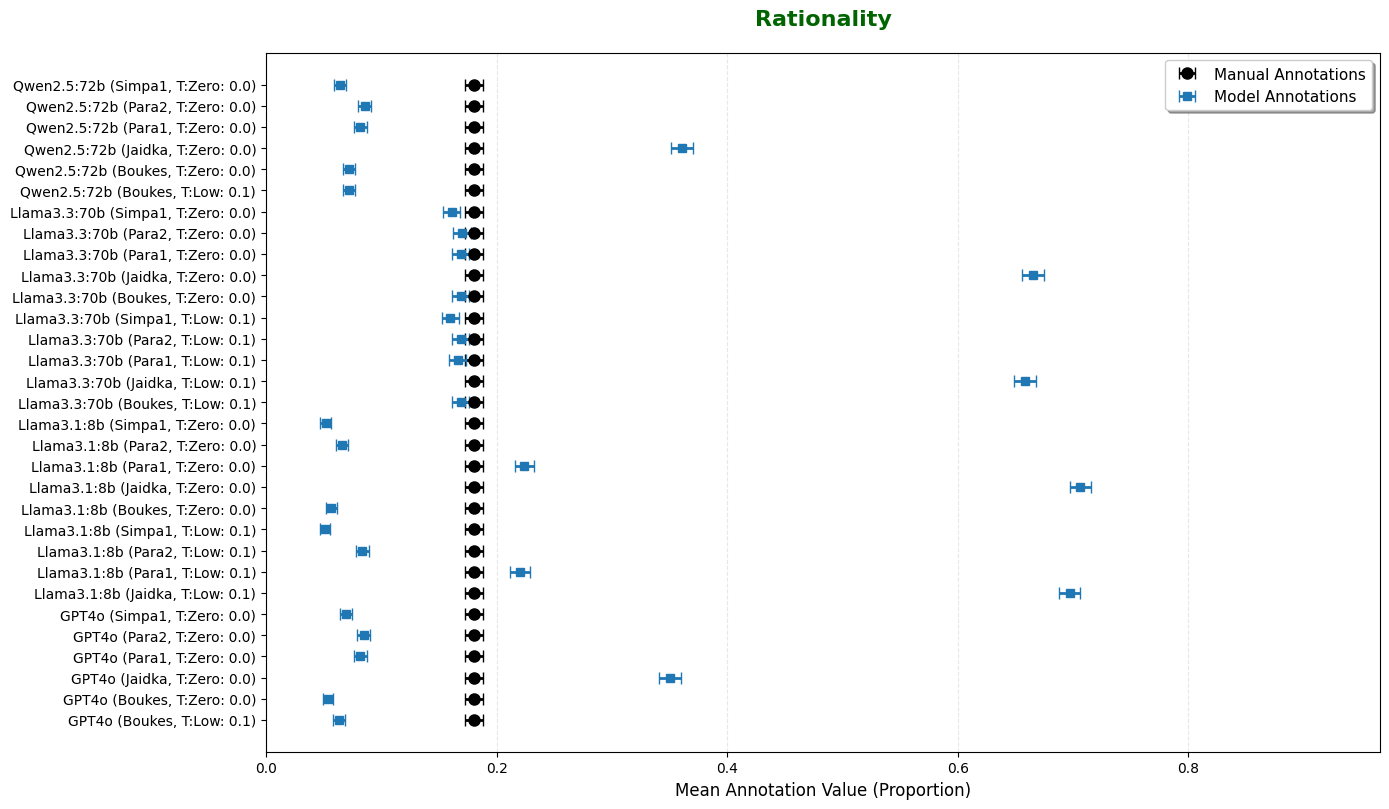

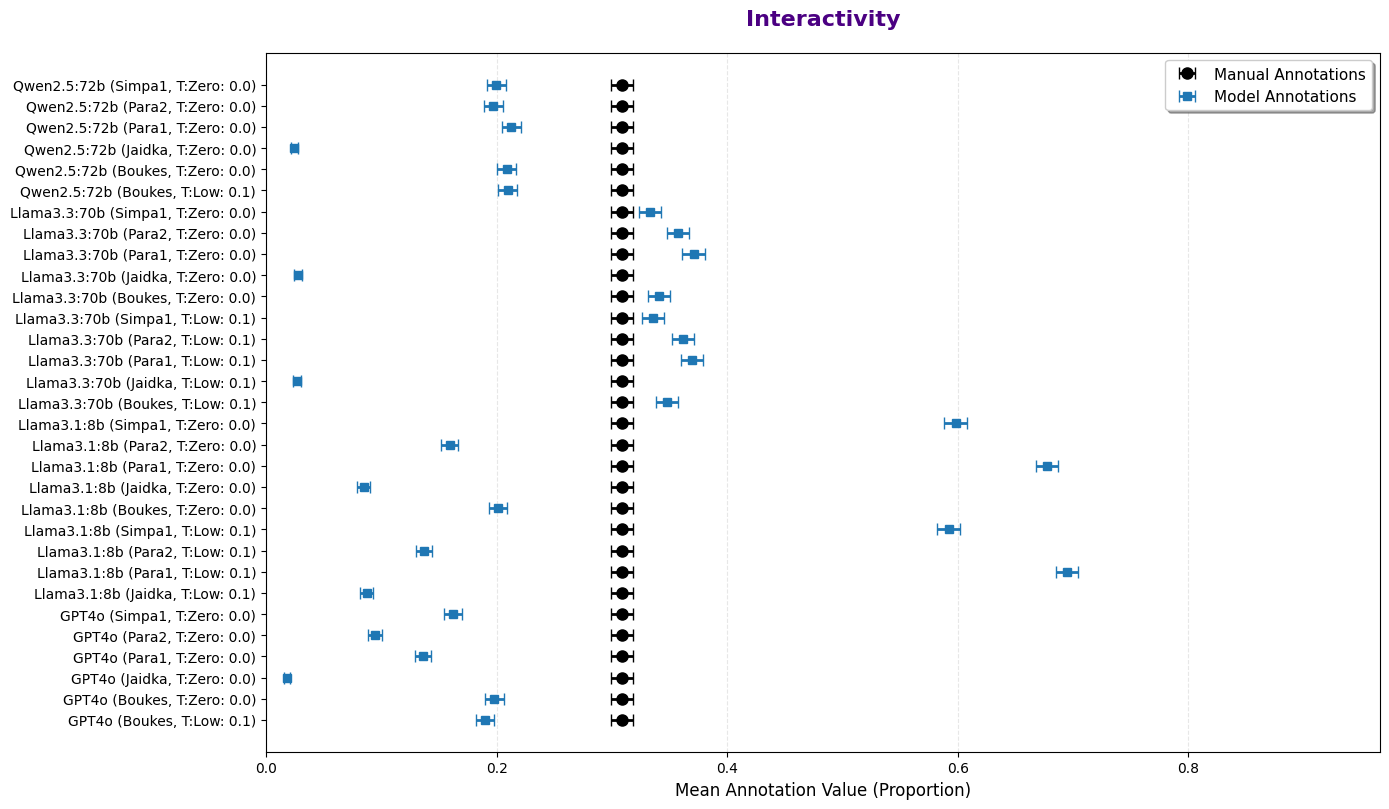

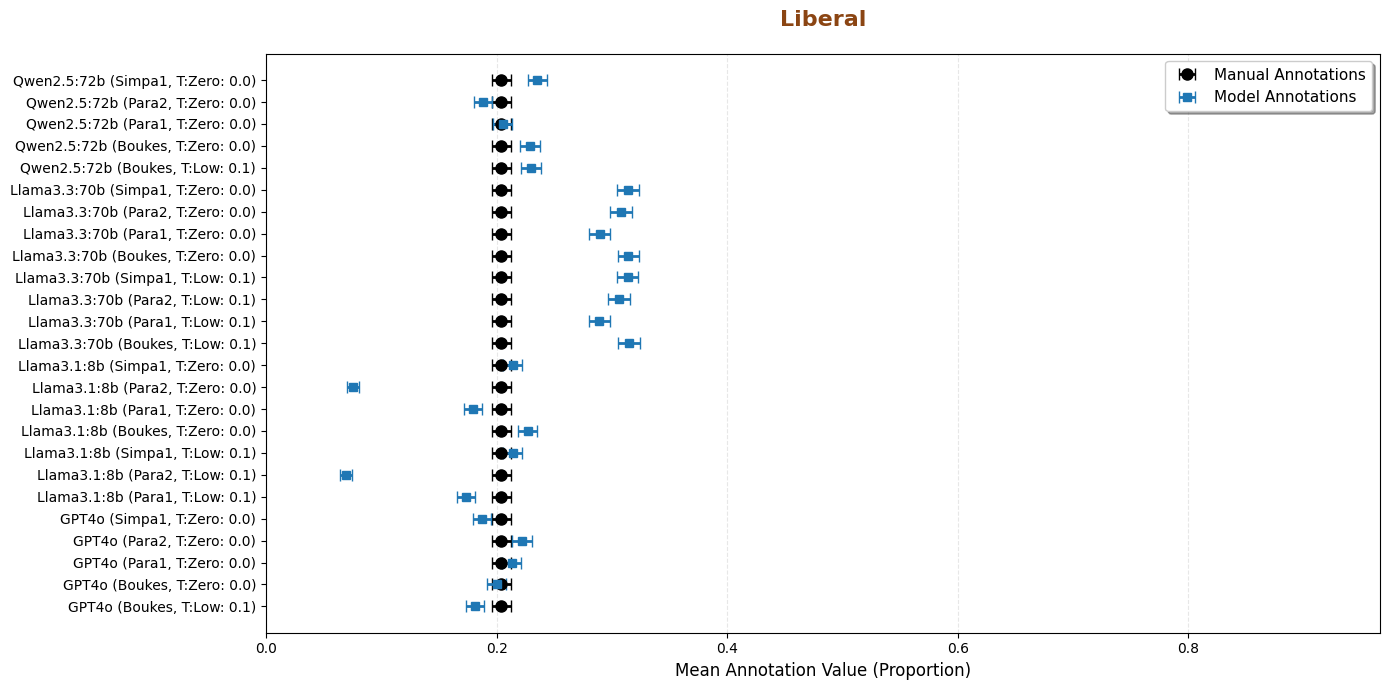

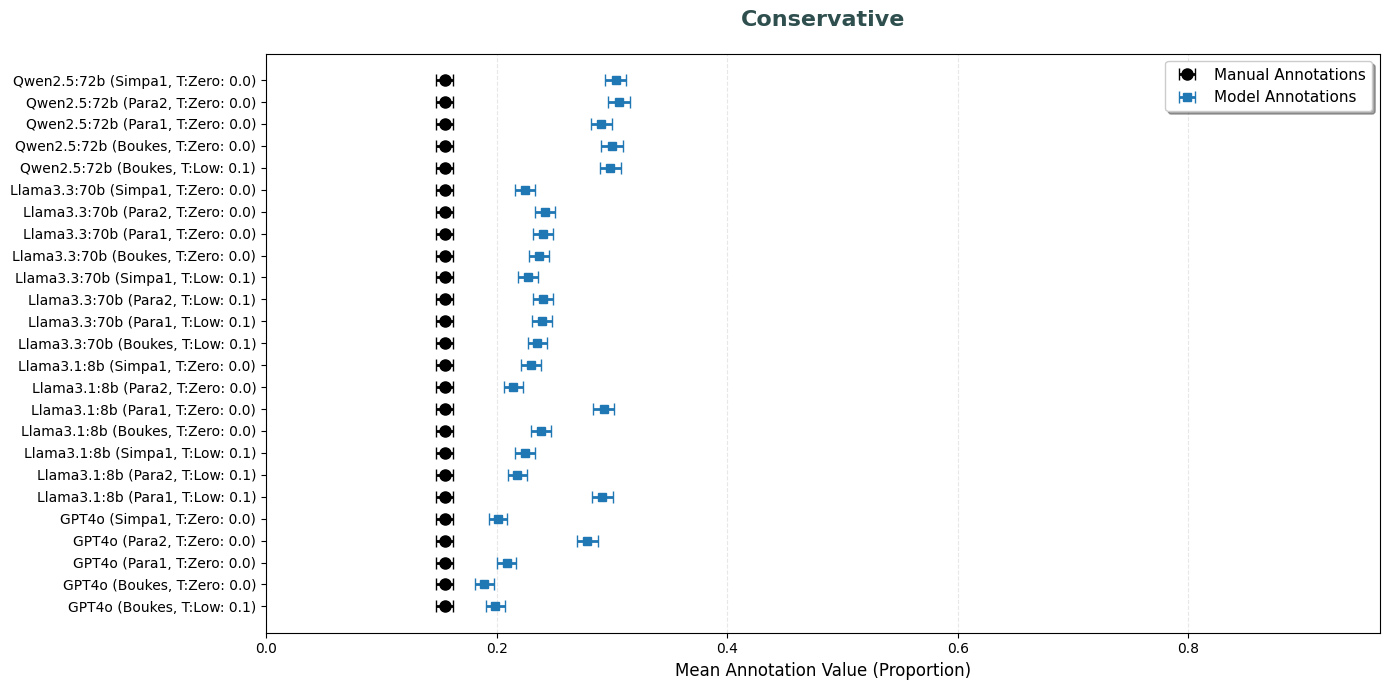

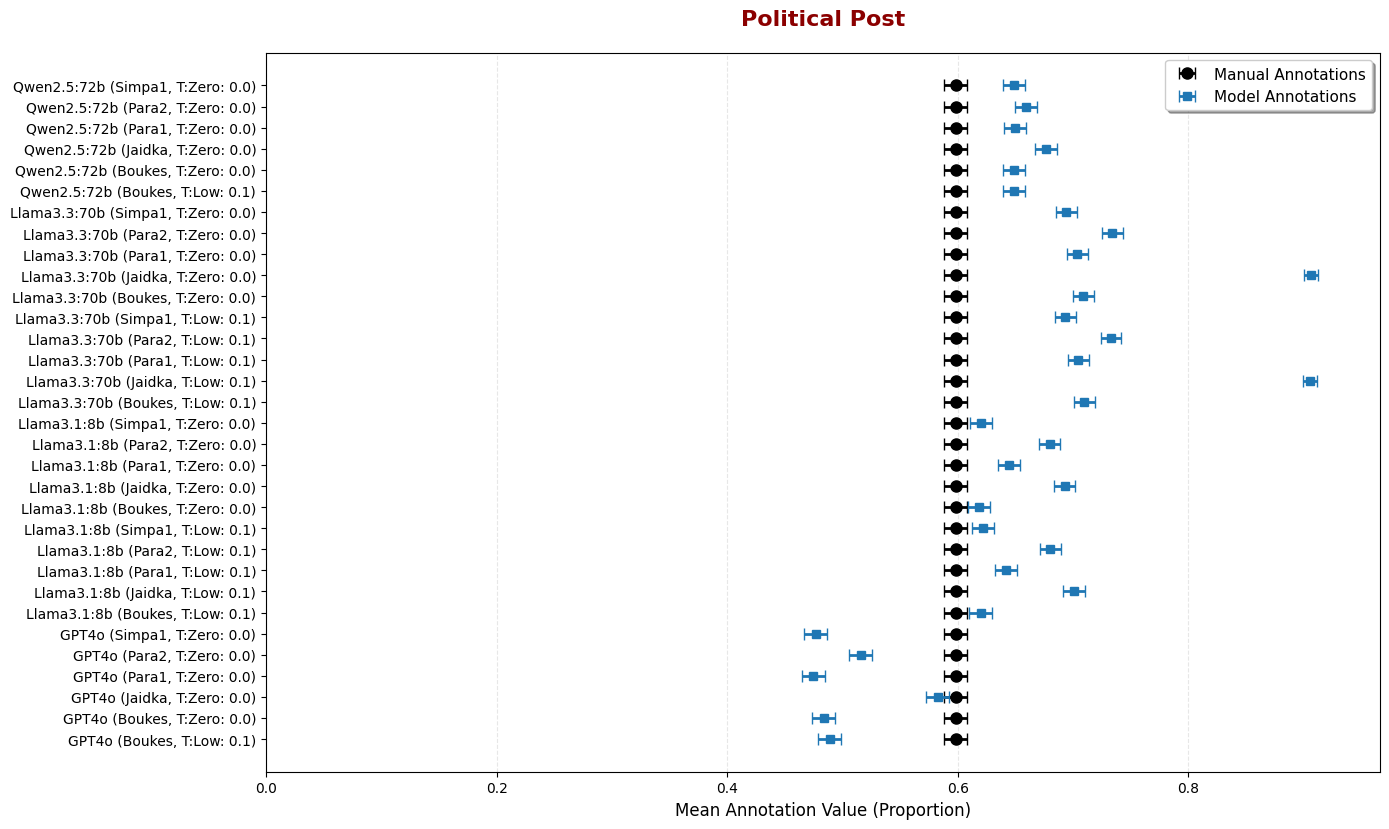

In [ ]:
# Function to plot model significance results as separate plots per concept
def plot_model_significance_results_with_ci(results_df):
    """
    Plot the significance results of models compared to manual annotations.
    Each concept gets its own separate plot with model and manual annotations displayed correctly.
    
    Parameters:
    - results_df: DataFrame containing significance results for each model column
    """
    
    if results_df.empty:
        print("No results to plot.")
        return
    
    # Create a copy to avoid modifying the original DataFrame
    df_plot = results_df.copy()
    
    # Prepare the data for plotting
    df_plot['model_label'] = df_plot.apply(
        lambda row: f"{row['model']} ({row['prompt_variant']}, T:{row['temperature']})", axis=1
    )
    
    # Get unique concepts
    concepts = df_plot['concept'].unique()
    
    # Calculate global x-axis limits to ensure consistency across all plots
    global_x_min = min(df_plot['manual_mean'].min() - df_plot['manual_std'].max(),
                       df_plot['model_mean'].min() - df_plot['model_std'].max()) - 0.02
    global_x_max = min(1.0, max(df_plot['manual_mean'].max() + df_plot['manual_std'].max(),
                               df_plot['model_mean'].max() + df_plot['model_std'].max()) + 0.05)
    global_x_min = max(0.0, global_x_min)  # Don't go below 0.0
    
    concept_colors = ['#8B0000', '#006400', '#4B0082', '#8B4513', '#2F4F4F']
    
    # Create separate plot for each concept
    for concept_idx, concept in enumerate(concepts):
        concept_data = df_plot[df_plot['concept'] == concept]
        
        # Sort the data by model, temperature, prompt_variant
        concept_data = concept_data.sort_values(['model', 'temperature', 'prompt_variant'])
        
        concept_color = concept_colors[concept_idx % len(concept_colors)]
        
        # Calculate figure height based on number of models
        row_height = 0.2
        fig_height = max(4, len(concept_data) * row_height + 2)
        
        # Create individual plot
        plt.figure(figsize=(14, fig_height))
        
        y_positions = range(len(concept_data))
        
        for i, (idx, row) in enumerate(concept_data.iterrows()):
            y_pos = i
            
            # Plot manual mean with confidence interval (standard error)
            plt.errorbar(
                x=row['manual_mean'],
                y=y_pos,
                xerr=row['manual_std'],
                fmt='o',
                label='Manual Annotations' if i == 0 else "",
                color='black',
                capsize=4,
                markersize=8,
                linewidth=2,
                zorder=3
            )
            
            # Plot model mean with confidence interval (standard error)
            plt.errorbar(
                x=row['model_mean'],
                y=y_pos,
                xerr=row['model_std'],
                fmt='s',
                label='Model Annotations' if i == 0 else "",
                color='#1f77b4',
                capsize=4,
                markersize=6,
                linewidth=2,
                zorder=3
            )
        
        # Set y-tick labels with better spacing
        plt.yticks(y_positions, [row['model_label'] for _, row in concept_data.iterrows()], fontsize=10)
        
        # Styling for each plot
        plt.title(f'{concept}', fontsize=16, fontweight='bold', color=concept_color, pad=20)
        plt.xlabel('Mean Annotation Value (Proportion)', fontsize=12)
        plt.grid(True, axis='x', alpha=0.3, linestyle='--')
        
        # Set consistent x-axis limits across all plots
        plt.xlim(global_x_min, global_x_max)
        
        # Ensure adequate spacing between y-tick labels
        plt.margins(y=0.05)
        
        # Add legend to each plot
        plt.legend(loc='upper right', frameon=True, fancybox=True, shadow=True, fontsize=11)
        
        plt.tight_layout()
        
        # Show the plot
        plt.show()

# Plot the significance results
plot_model_significance_results_with_ci(final_results_df)
    

# Replicate the multilevel logistic regression analyses in Boukes, 2024.

In [14]:
#calculate the F1 macro score for each prompt variant, temperature and model per concept
# Create a dictionary from the boukes_concepts_info list for easy lookup
concepts_dict = dict(boukes_concepts_info)

# Initialize list to store results
results = []

for col in model_columns_alltemps:
    labels = get_labels(col)
    concept = labels['concept']
    gt_col = concepts_dict.get(concept, None)
    if gt_col is None:
        print(f"Warning: No ground truth column found for concept '{concept}' in column '{col}'")
        continue
    model = labels['model']
    prompt_variant = labels['prompt_variant']
    temperature = labels.get('temperature', 'N/A')
    
    # Calculate F1 macro score
    f1_macro = get_macro_f1_score(boukes2024, col, gt_col)
    
    # Store results in list
    results.append({
        'concept': concept,
        'column_name': col,
        'model': model,
        'prompt_variant': prompt_variant,
        'temperature': temperature,
        'macro_f1': f1_macro
    })
    
    print(f"F1 Macro Score for {concept} ({model}, {prompt_variant}, Temp: {temperature}): {f1_macro:.4f}")

# Create dataframe from results
concept_model_f1_df = pd.DataFrame(results)

# Sort by concept and then by macro_f1 descending within each concept
concept_model_f1_df = concept_model_f1_df.sort_values(['concept', 'macro_f1'], ascending=[True, False])

# Reset index for clean display
concept_model_f1_df = concept_model_f1_df.reset_index(drop=True)

print(f"\n{'='*80}")
print("F1 MACRO SCORES SUMMARY")
print('='*80)
print(f"Total evaluations: {len(concept_model_f1_df)}")
print(f"Concepts evaluated: {concept_model_f1_df['concept'].nunique()}")
print(f"Models tested: {concept_model_f1_df['model'].nunique()}")
print(f"Prompt variants: {concept_model_f1_df['prompt_variant'].nunique()}")

# Display the dataframe
print(f"\nConcept-Model F1 Performance (sorted by concept, then F1 descending):")
print(concept_model_f1_df.to_string(index=False, float_format='%.4f'))

# Show best performing model per concept
print(f"\n{'='*80}")
print("BEST PERFORMING MODEL PER CONCEPT")
print('='*80)
best_per_concept = concept_model_f1_df.groupby('concept').first().reset_index()
for _, row in best_per_concept.iterrows():
    print(f"{row['concept']:15} | {row['model']:15} | {row['prompt_variant']:10} | {row['temperature']:10} | F1: {row['macro_f1']:.4f}")

print(f"\n{'='*80}")

F1 Macro Score for Incivility (GPT4o, Boukes, Temp: Zero: 0.0): 0.7390
F1 Macro Score for Rationality (GPT4o, Boukes, Temp: Zero: 0.0): 0.6347
F1 Macro Score for Interactivity (GPT4o, Boukes, Temp: Zero: 0.0): 0.7366
F1 Macro Score for Rationality (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7261
F1 Macro Score for Incivility (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7511
F1 Macro Score for Political Post (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7924
F1 Macro Score for Rationality (Llama3.3:70b, Jaidka, Temp: Low: 0.1): 0.4943
F1 Macro Score for Incivility (Llama3.3:70b, Jaidka, Temp: Low: 0.1): 0.7480
F1 Macro Score for Political Post (Llama3.3:70b, Jaidka, Temp: Low: 0.1): 0.5746
F1 Macro Score for Conservative (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7800
F1 Macro Score for Liberal (Llama3.3:70b, Boukes, Temp: Low: 0.1): 0.7608
F1 Macro Score for Conservative (Llama3.3:70b, Para1, Temp: Low: 0.1): 0.7817
F1 Macro Score for Liberal (Llama3.3:70b, Para1, Temp: Low: 0.1): 0.7740
F1 Macr

In [15]:
#make a dataframe based on the columns in boukes2024 with the best performing columns per concept based on concept_model_f1_df, the ground truth columns per concept based on boukes_concepts_info, 
# and the genre_paper column, the topic, the year  (Time_comment_year) 
# call this df logregres_df

#get the best performing model column per concept
best_model_columns = []
gt_columns = []

for concept in boukes_concepts_info:
    concept_name = concept[0]
    gt_col = concept[1]
    
    # Filter the DataFrame for the current concept
    concept_df = concept_model_f1_df[concept_model_f1_df['concept'] == concept_name]
    
    if len(concept_df) > 0:
        # Get the best performing model column for this concept (first row since it's sorted by F1 descending)
        best_model_col = concept_df.iloc[0]['column_name']
        best_model_columns.append(best_model_col)
        gt_columns.append(gt_col)
        print(f"Best model for {concept_name}: {best_model_col} (F1: {concept_df.iloc[0]['macro_f1']:.4f})")
    else:
        print(f"Warning: No models found for concept {concept_name}")

# Combine all columns needed for the regression dataframe
all_columns = ['genre_paper', 'topic', 'Time_comment_year', 'showName'] + best_model_columns + gt_columns

# Remove any columns that don't exist in boukes2024
existing_columns = [col for col in all_columns if col in boukes2024.columns]
missing_columns = [col for col in all_columns if col not in boukes2024.columns]

if missing_columns:
    print(f"Warning: Missing columns in boukes2024: {missing_columns}")

print(f"Creating logregres_df with {len(existing_columns)} columns: {existing_columns}")

# Create the regression dataframe
logregres_df = boukes2024[existing_columns].copy()

print(f"logregres_df shape: {logregres_df.shape}")
print(f"logregres_df columns: {list(logregres_df.columns)}")
print(f"\nFirst few rows:")
print(logregres_df.head())
    



Best model for Incivility: incivility_jaidka_Q25_72b_zero_dum (F1: 0.7617)
Best model for Rationality: rationality_simple2_para2_L33_70b_low_dum (F1: 0.7303)
Best model for Interactivity: interactivity_acknowledgement_simple_L33_70b_zero_dum (F1: 0.7692)
Best model for Liberal: political_ideology_US_para1_gpt4o_system_zero_lib_dum (F1: 0.7968)
Best model for Conservative: political_ideology_US_gpt4o_system_zero_con_dum (F1: 0.8167)
Best model for Political Post: political_post_jaidka_gpt4o_system_zero_dum (F1: 0.8377)
Creating logregres_df with 16 columns: ['genre_paper', 'topic', 'Time_comment_year', 'showName', 'incivility_jaidka_Q25_72b_zero_dum', 'rationality_simple2_para2_L33_70b_low_dum', 'interactivity_acknowledgement_simple_L33_70b_zero_dum', 'political_ideology_US_para1_gpt4o_system_zero_lib_dum', 'political_ideology_US_gpt4o_system_zero_con_dum', 'political_post_jaidka_gpt4o_system_zero_dum', 'INCIVILITY_DUMMY', 'RATIONALITY_DUMMY', 'INTERACTIVITY_DUMMY', 'LIBERAL_DUMMY', 'CO

In [16]:
# Prepare categorical variables efficiently
categorical_cols = ['genre_paper', 'Time_comment_year', 'topic']
logregres_df[categorical_cols] = logregres_df[categorical_cols].astype('category')

#set satire as reference category:
logregres_df['genre_paper'] = logregres_df['genre_paper'].cat.reorder_categories(
    ['satire'] + sorted([c for c in logregres_df['genre_paper'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "interactivity_acknowledgement_simple_L33_70b_zero_dum ~ "
    "rationality_simple2_para2_L33_70b_low_dum + "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_para1_gpt4o_system_zero_lib_dum + "
    "incivility_jaidka_Q25_72b_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + "
    "political_post_jaidka_gpt4o_system_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=logregres_df
)
result = model.fit_map()

# Print the full summary
print(result.summary())


                                     Binomial Mixed GLM Results
                                                      Type Post. Mean Post. SD   SD  SD (LB) SD (UB)
----------------------------------------------------------------------------------------------------
Intercept                                                M    -0.3543   0.4272                      
C(genre_paper)[T.conservative partisan news]             M    -0.0796   0.1370                      
C(genre_paper)[T.liberal partisan news]                  M    -0.0205   0.1328                      
C(genre_paper)[T.regular news]                           M    -0.1992   0.1194                      
C(Time_comment_year)[T.2015]                             M     0.1230   0.5227                      
C(Time_comment_year)[T.2016]                             M     0.6563   0.4579                      
C(Time_comment_year)[T.2017]                             M    -0.1770   0.4471                      
C(Time_comment_year)[T.2018

In [17]:

fe_mean = result.fe_mean
fe_sd = result.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table['P>|z|'] = results_table['P>|z|'].apply(format_pvalue)

print(results_table)


                                                       Coefficient  \
Intercept                                                -0.354277   
C(genre_paper)[T.conservative partisan news]             -0.079628   
C(genre_paper)[T.liberal partisan news]                  -0.020527   
C(genre_paper)[T.regular news]                           -0.199235   
C(Time_comment_year)[T.2015]                              0.123043   
C(Time_comment_year)[T.2016]                              0.656314   
C(Time_comment_year)[T.2017]                             -0.176958   
C(Time_comment_year)[T.2018]                             -0.064192   
C(Time_comment_year)[T.2019]                              0.021007   
C(topic)[T.economy]                                      -0.133066   
C(topic)[T.mueller]                                       0.075840   
rationality_simple2_para2_L33_70b_low_dum                 1.282648   
political_ideology_US_para1_gpt4o_system_zero_lib_dum     0.041538   
incivility_jaidka_Q2

In [10]:
#repeat with default annotations

#set satire as reference category:
boukes2024['genre_paper_cat'] = boukes2024['genre_paper'].astype('category')
boukes2024['genre_paper_cat'] = boukes2024['genre_paper_cat'].cat.reorder_categories(
    ['satire'] + sorted([c for c in boukes2024['genre_paper_cat'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "interactivity_acknowledgement_simple_L33_70b_zero_dum ~ "
    "rationality_simple2_L33_70b_zero_dum + "
    "C(genre_paper_cat) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_L33_70b_zero_lib_dum + "
    "incivility_simple2_L33_70b_zero_dum + "
    "political_ideology_US_L33_70b_zero_con_dum + "
    "political_post_L33_70b_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=boukes2024 
)
result_L33_70b_zero = model.fit_map()

fe_mean = result_L33_70b_zero.fe_mean
fe_sd = result_L33_70b_zero.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table_L33_70b_zero = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result_L33_70b_zero.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table_L33_70b_zero.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table_L33_70b_zero['P>|z|'] = results_table_L33_70b_zero['P>|z|'].apply(format_pvalue)

print(results_table_L33_70b_zero)

                                                  Coefficient  Std. Error  \
Intercept                                           -0.345956    0.429219   
C(genre_paper_cat)[T.conservative partisan news]    -0.067343    0.137205   
C(genre_paper_cat)[T.liberal partisan news]         -0.036615    0.132895   
C(genre_paper_cat)[T.regular news]                  -0.219592    0.119287   
C(Time_comment_year)[T.2015]                         0.236288    0.522988   
C(Time_comment_year)[T.2016]                         0.714909    0.457576   
C(Time_comment_year)[T.2017]                        -0.164668    0.446422   
C(Time_comment_year)[T.2018]                        -0.019806    0.432706   
C(Time_comment_year)[T.2019]                         0.064709    0.432001   
C(topic)[T.economy]                                 -0.136533    0.111264   
C(topic)[T.mueller]                                  0.092989    0.111272   
rationality_simple2_L33_70b_zero_dum                 1.330898    0.119960   

In [11]:
#repeat with gpt4o annotations

#repeat with default annotations

#set satire as reference category:
boukes2024['genre_paper_cat'] = boukes2024['genre_paper'].astype('category')
boukes2024['genre_paper_cat'] = boukes2024['genre_paper_cat'].cat.reorder_categories(
    ['satire'] + sorted([c for c in boukes2024['genre_paper_cat'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "interactivity_acknowledgement_simple_gpt4o_system_zero_dum ~ "
    "rationality_simple2_gpt4o_system_zero_dum + "
    "C(genre_paper_cat) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_gpt4o_system_zero_lib_dum + "
    "incivility_simple2_gpt4o_system_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + "
    "political_post_gpt4o_system_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=boukes2024 
)
result_gpt4o_zero = model.fit_map()

fe_mean = result_gpt4o_zero.fe_mean
fe_sd = result_gpt4o_zero.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table_gpt4o_zero = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result_gpt4o_zero.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table_gpt4o_zero.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table_gpt4o_zero['P>|z|'] = results_table_gpt4o_zero['P>|z|'].apply(format_pvalue)

print(results_table_gpt4o_zero)

                                                  Coefficient  Std. Error  \
Intercept                                           -1.434413    0.481625   
C(genre_paper_cat)[T.conservative partisan news]    -0.131709    0.160589   
C(genre_paper_cat)[T.liberal partisan news]          0.011481    0.153657   
C(genre_paper_cat)[T.regular news]                  -0.132274    0.137585   
C(Time_comment_year)[T.2015]                         0.611104    0.575756   
C(Time_comment_year)[T.2016]                         0.773318    0.509349   
C(Time_comment_year)[T.2017]                        -0.159937    0.509757   
C(Time_comment_year)[T.2018]                        -0.153270    0.491643   
C(Time_comment_year)[T.2019]                         0.396636    0.488718   
C(topic)[T.economy]                                 -0.066657    0.128718   
C(topic)[T.mueller]                                  0.102911    0.129112   
rationality_simple2_gpt4o_system_zero_dum            1.016319    0.196479   

In [ ]:
#repeat for political post as DV:

# Prepare categorical variables efficiently
categorical_cols = ['genre_paper', 'Time_comment_year', 'topic']
logregres_df[categorical_cols] = logregres_df[categorical_cols].astype('category')

#set satire as reference category:
logregres_df['genre_paper'] = logregres_df['genre_paper'].cat.reorder_categories(
    ['satire'] + sorted([c for c in logregres_df['genre_paper'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "political_post_jaidka_gpt4o_system_zero_dum ~ "
    "rationality_simple2_para2_L33_70b_low_dum + "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_para1_gpt4o_system_zero_lib_dum + "
    "incivility_jaidka_Q25_72b_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + interactivity_acknowledgement_simple_L33_70b_zero_dum"

)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=logregres_df
)
result = model.fit_map()

fe_mean = result.fe_mean
fe_sd = result.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table['P>|z|'] = results_table['P>|z|'].apply(format_pvalue)

print(results_table)



                                                       Coefficient  \
Intercept                                                -1.597866   
C(genre_paper)[T.conservative partisan news]              0.219458   
C(genre_paper)[T.liberal partisan news]                   0.421229   
C(genre_paper)[T.regular news]                           -0.023694   
C(Time_comment_year)[T.2015]                             -0.051485   
C(Time_comment_year)[T.2016]                             -0.071684   
C(Time_comment_year)[T.2017]                              0.094651   
C(Time_comment_year)[T.2018]                              0.321334   
C(Time_comment_year)[T.2019]                              0.564259   
C(topic)[T.economy]                                      -0.685773   
C(topic)[T.mueller]                                       0.031060   
rationality_simple2_para2_L33_70b_low_dum                 1.906800   
political_ideology_US_para1_gpt4o_system_zero_lib_dum     3.108392   
incivility_jaidka_Q2

In [18]:
#repeat for rationality as DV:

# Prepare categorical variables efficiently
categorical_cols = ['genre_paper', 'Time_comment_year', 'topic']
logregres_df[categorical_cols] = logregres_df[categorical_cols].astype('category')

#set satire as reference category:
logregres_df['genre_paper'] = logregres_df['genre_paper'].cat.reorder_categories(
    ['satire'] + sorted([c for c in logregres_df['genre_paper'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "rationality_simple2_para2_L33_70b_low_dum ~ "
    "C(genre_paper) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_para1_gpt4o_system_zero_lib_dum + "
    "incivility_jaidka_Q25_72b_zero_dum + "
    "political_ideology_US_gpt4o_system_zero_con_dum + interactivity_acknowledgement_simple_L33_70b_zero_dum + "
    "political_post_jaidka_gpt4o_system_zero_dum"
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=logregres_df
)
result = model.fit_map()

fe_mean = result.fe_mean
fe_sd = result.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
results_table = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

results_table.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

results_table['P>|z|'] = results_table['P>|z|'].apply(format_pvalue)

print(results_table)



                                                       Coefficient  \
Intercept                                                -2.423652   
C(genre_paper)[T.conservative partisan news]             -0.153293   
C(genre_paper)[T.liberal partisan news]                  -0.387281   
C(genre_paper)[T.regular news]                            0.095891   
C(Time_comment_year)[T.2015]                             -0.023180   
C(Time_comment_year)[T.2016]                              0.132277   
C(Time_comment_year)[T.2017]                              0.073830   
C(Time_comment_year)[T.2018]                             -0.553528   
C(Time_comment_year)[T.2019]                             -0.804931   
C(topic)[T.economy]                                      -0.093338   
C(topic)[T.mueller]                                      -0.157609   
political_ideology_US_para1_gpt4o_system_zero_lib_dum     0.885119   
incivility_jaidka_Q25_72b_zero_dum                       -1.148394   
political_ideology_U

In [19]:
#repeat with jaidka annotations

#set satire as reference category:
boukes2024['genre_paper_cat'] = boukes2024['genre_paper'].astype('category')
boukes2024['genre_paper_cat'] = boukes2024['genre_paper_cat'].cat.reorder_categories(
    ['satire'] + sorted([c for c in boukes2024['genre_paper_cat'].cat.categories if c != 'satire'])
)

# Define formula with proper concatenation
formula = (
    "reciprocity_jaidka_L33_70b_zero_dum ~ "
    "rationality_jaidka_L33_70b_zero_dum + "
    "C(genre_paper_cat) + C(Time_comment_year) + C(topic) + "
    "political_ideology_US_L33_70b_zero_lib_dum + "
    "incivility_jaidka_L33_70b_zero_dum + "
    "political_ideology_US_L33_70b_zero_con_dum + "
    "political_post_jaidka_L33_70b_zero_dum "
)

# Specify random effects
random_effects = {"group_intercept": "0 + C(showName)"}

# Initialize and fit the model
model = BinomialBayesMixedGLM.from_formula(
    formula, 
    random_effects, 
    data=boukes2024 
)
result_L33_70b_jaidka = model.fit_map()

fe_mean = result_L33_70b_jaidka.fe_mean
fe_sd = result_L33_70b_jaidka.fe_sd

# Calculate z and p
z_scores = fe_mean / fe_sd
p_values = 2 * stats.norm.sf(abs(z_scores))

# Create DataFrame
result_L33_70b_jaidka = pd.DataFrame({
    'Coefficient': fe_mean,
    'Std. Error': fe_sd,
    'z': z_scores,
    'P>|z|': p_values
})

# Try to get variable names (if available)
try:
    variable_names = result_L33_70b_jaidka.fe_names
except AttributeError:
    try:
        # Try to get from model, if possible
        variable_names = model.exog_names
    except AttributeError:
        # Fallback: use generic names if nothing else works
        variable_names = [f'var_{i}' for i in range(len(fe_mean))]
        print("Warning: Could not get variable names from result or model. Using generic names.")

result_L33_70b_jaidka.index = variable_names

# Format p-values
def format_pvalue(p):
    if p < 0.001:
        return "<0.001"
    else:
        return f"{p:.3f}"

result_L33_70b_jaidka['P>|z|'] = result_L33_70b_jaidka['P>|z|'].apply(format_pvalue)

print(result_L33_70b_jaidka)

                                                  Coefficient  Std. Error  \
Intercept                                           -3.059565    0.764152   
C(genre_paper_cat)[T.conservative partisan news]    -0.581100    0.434727   
C(genre_paper_cat)[T.liberal partisan news]          0.270400    0.333908   
C(genre_paper_cat)[T.regular news]                  -0.588465    0.341178   
C(Time_comment_year)[T.2015]                        -0.247081    1.052997   
C(Time_comment_year)[T.2016]                         0.224441    0.777478   
C(Time_comment_year)[T.2017]                        -0.716299    0.848343   
C(Time_comment_year)[T.2018]                         0.229105    0.728248   
C(Time_comment_year)[T.2019]                         0.259094    0.727198   
C(topic)[T.economy]                                  0.066821    0.287040   
C(topic)[T.mueller]                                 -0.240943    0.328078   
rationality_jaidka_L33_70b_zero_dum                  0.372300    0.290376   

# Bivariate correlations satire_video_dummy vs concept annotations

In [ ]:
#what if we reduce complexity by only focussing on bivariate relations between genre_paper_dum (satire vs non satire) and the concepts versus manual
# plot correlations coefficients and se per model in a graph with a line for the human ground truth correlations/dots with se for human as well
#would we have reached substantively different conclusions about these relations than in the paper and based on the choice of model/prompt variant/temperature?


In [20]:
# COMPREHENSIVE ANALYSIS FOR ALL CONCEPTS
# Extend the approach to all concepts in boukes_concepts_info

def get_model_columns_by_concept(concept_name):
    """
    Get all model columns related to a specific concept.
    
    Args:
    - concept_name: The concept to search for
    
    Returns:
    - List of model column names for the concept
    """
    concept_columns = []
    for col in model_columns_alltemps:
        labels = get_labels(col)
        if labels['concept'] == concept_name:
            concept_columns.append(col)
    return concept_columns

def get_ground_truth_column(concept_name):
    """
    Get the ground truth column for a specific concept from boukes_concepts_info.
    
    Args:
    - concept_name: The concept to search for
    
    Returns:
    - Ground truth column name or None if not found
    """
    for concept, manual_col in boukes_concepts_info:
        if concept == concept_name:
            return manual_col
    return None

def analyze_concept_correlations(concept_name, reference_variable='genre_paper_dum'):
    """
    Analyze correlations for all models of a specific concept with a reference variable.
    
    Args:
    - concept_name: The concept to analyze
    - reference_variable: Variable to correlate with (default: genre_paper_dum)
    
    Returns:
    - Dictionary with results
    """
    print(f"\n{'='*60}")
    print(f"ANALYZING CONCEPT: {concept_name}")
    print(f"{'='*60}")
    
    # Get model columns for this concept
    model_columns = get_model_columns_by_concept(concept_name)
    
    # Get ground truth column
    gt_column = get_ground_truth_column(concept_name)
    
    if gt_column is None:
        print(f"Warning: No ground truth column found for concept '{concept_name}'")
        return None
    
    if len(model_columns) == 0:
        print(f"Warning: No model columns found for concept '{concept_name}'")
        return None
    
    print(f"Ground truth column: {gt_column}")
    print(f"Number of model columns: {len(model_columns)}")
    print(f"Reference variable: {reference_variable}")
    
    # Add ground truth to the list for analysis
    all_columns = model_columns + [gt_column]
    
    # Calculate correlations for all columns
    results = []
    for col in all_columns:
        if col not in boukes2024.columns:
            print(f"Warning: Column '{col}' not found in dataset")
            continue
            
        try:
            # Calculate correlation with reference variable
            correlation = boukes2024[[col, reference_variable]].corr().iloc[0, 1]
            
            # Calculate standard error of the correlation
            n = len(boukes2024.dropna(subset=[col, reference_variable]))
            se = np.sqrt((1 - correlation**2) / (n - 2))
            
            # Calculate p-value
            from scipy import stats
            t_stat = correlation * np.sqrt((n - 2) / (1 - correlation**2))
            p_value = 2 * stats.t.sf(abs(t_stat), n - 2)
            p_value_formatted = f"{p_value:.3f}" if p_value >= 0.001 else "<0.001"
            
            results.append({
                'concept': concept_name,
                'model_column': col,
                'correlation': correlation,
                'se': se,
                'p_value': p_value,
                'p_formatted': p_value_formatted,
                'n_obs': n,
                'is_ground_truth': col == gt_column
            })
            
        except Exception as e:
            print(f"Error calculating correlation for {col}: {e}")
            continue
    
    if len(results) == 0:
        print(f"No valid results found for concept '{concept_name}'")
        return None
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Print summary
    print(f"\nCorrelation Results with {reference_variable}:")
    print("-" * 50)
    for _, row in results_df.iterrows():
        marker = " [GT]" if row['is_ground_truth'] else ""
        print(f"{row['model_column'][:50]}{marker}")
        print(f"  r = {row['correlation']:.4f} (SE = {row['se']:.4f}, p = {row['p_formatted']}, n = {row['n_obs']})")
    
    return {
        'concept': concept_name,
        'ground_truth_column': gt_column,
        'results_df': results_df,
        'model_columns': model_columns
    }

# Run analysis for all concepts
print("COMPREHENSIVE CORRELATION ANALYSIS FOR ALL CONCEPTS")
print("="*80)

all_concept_results = {}
all_concepts = [concept for concept, _ in boukes_concepts_info]
unique_concepts = list(set(all_concepts))  # Remove duplicates

print(f"Found {len(unique_concepts)} unique concepts: {unique_concepts}")

for concept in unique_concepts:
    try:
        result = analyze_concept_correlations(concept, 'genre_paper_dum')
        if result is not None:
            all_concept_results[concept] = result
    except Exception as e:
        print(f"Error analyzing concept '{concept}': {e}")
        continue

print(f"\n{'='*80}")
print("SUMMARY OF ALL CONCEPTS")
print(f"{'='*80}")

if all_concept_results:
    summary_data = []
    for concept, result in all_concept_results.items():
        df = result['results_df']
        gt_row = df[df['is_ground_truth']]
        model_rows = df[~df['is_ground_truth']]
        
        if len(gt_row) > 0 and len(model_rows) > 0:
            gt_corr = gt_row['correlation'].iloc[0]
            model_corrs = model_rows['correlation']
            
            summary_data.append({
                'concept': concept,
                'ground_truth_correlation': gt_corr,
                'n_models': len(model_rows),
                'mean_model_correlation': model_corrs.mean(),
                'std_model_correlation': model_corrs.std(),
                'min_model_correlation': model_corrs.min(),
                'max_model_correlation': model_corrs.max()
            })
    
    summary_df = pd.DataFrame(summary_data)
    
    print("Concept Summary:")
    display(summary_df)
    
    # Store results for further analysis
    globals()['all_concept_results'] = all_concept_results
    globals()['concept_summary_df'] = summary_df
    
    print(f"\nResults stored in variables:")
    print("- all_concept_results: Detailed results for each concept")
    print("- concept_summary_df: Summary statistics across concepts")
    
else:
    print("No valid results found for any concept.")

COMPREHENSIVE CORRELATION ANALYSIS FOR ALL CONCEPTS
Found 6 unique concepts: ['Rationality', 'Interactivity', 'Incivility', 'Conservative', 'Liberal', 'Political Post']

ANALYZING CONCEPT: Rationality
Ground truth column: RATIONALITY_DUMMY
Number of model columns: 31
Reference variable: genre_paper_dum

Correlation Results with genre_paper_dum:
--------------------------------------------------
rationality_simple2_gpt4o_system_zero_dum
  r = 0.0695 (SE = 0.0201, p = <0.001, n = 2459)
rationality_simple2_L33_70b_low_dum
  r = 0.0807 (SE = 0.0201, p = <0.001, n = 2459)
rationality_jaidka_L33_70b_low_dum
  r = 0.0253 (SE = 0.0202, p = 0.209, n = 2459)
rationality_simple2_para1_L33_70b_low_dum
  r = 0.0768 (SE = 0.0201, p = <0.001, n = 2459)
rationality_simple2_para2_L33_70b_low_dum
  r = 0.0762 (SE = 0.0201, p = <0.001, n = 2459)
rationality_simple2_simpa1_L33_70b_low_dum
  r = 0.0746 (SE = 0.0201, p = <0.001, n = 2459)
rationality_jaidka_L31_8b_low_dum
  r = 0.0146 (SE = 0.0202, p = 0.47

,concept,ground_truth_correlation,n_models,mean_model_correlation,std_model_correlation,min_model_correlation,max_model_correlation
0,Rationality,-0.018488,31,0.057072,0.021639,0.014559,0.083029
1,Interactivity,0.057976,31,0.051891,0.029795,-0.018741,0.099626
2,Incivility,-0.101522,31,-0.122715,0.020291,-0.165617,-0.078800
3,Conservative,-0.117780,25,-0.161742,0.017910,-0.186537,-0.129400
4,Liberal,-0.033360,25,0.028406,0.018587,-0.014128,0.053760
5,Political Post,-0.076856,32,-0.101326,0.014790,-0.129492,-0.064831



Results stored in variables:
- all_concept_results: Detailed results for each concept
- concept_summary_df: Summary statistics across concepts


In [21]:
# STATISTICAL SIGNIFICANCE TESTING FOR ALL CONCEPTS
# Compare each model with its corresponding ground truth across all concepts

def perform_statistical_comparison_for_concept(concept_results):
    """
    Perform statistical comparison of model correlations with ground truth for a single concept.
    
    Args:
    - concept_results: Results dictionary from analyze_concept_correlations
    
    Returns:
    - DataFrame with statistical comparison results
    """
    concept = concept_results['concept']
    results_df = concept_results['results_df']
    
    # Get ground truth correlation and SE
    gt_row = results_df[results_df['is_ground_truth']]
    model_rows = results_df[~results_df['is_ground_truth']]
    
    if len(gt_row) == 0:
        print(f"Warning: No ground truth found for concept '{concept}'")
        return None
    
    if len(model_rows) == 0:
        print(f"Warning: No model results found for concept '{concept}'")
        return None
    
    gt_corr = gt_row['correlation'].iloc[0]
    gt_se = gt_row['se'].iloc[0]
    n = gt_row['n_obs'].iloc[0]
    
    print(f"\n{'-'*60}")
    print(f"STATISTICAL COMPARISON FOR: {concept}")
    print(f"{'-'*60}")
    print(f"Ground Truth: {gt_corr:.4f} (SE: {gt_se:.4f})")
    
    # Statistical tests for correlation differences
    significance_results = []
    
    for _, row in model_rows.iterrows():
        model_name = row['model_column']
        model_corr = row['correlation']
        model_se = row['se']
        
        # Fisher's z-transformation for correlation comparison
        z_gt = 0.5 * np.log((1 + gt_corr) / (1 - gt_corr))
        z_model = 0.5 * np.log((1 + model_corr) / (1 - model_corr))
        
        # Standard error of the difference
        se_diff = np.sqrt(2 / (n - 3))
        
        # Z-test statistic
        z_stat = (z_model - z_gt) / se_diff
        
        # Two-tailed p-value
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))
        
        # Determine significance
        if p_value < 0.001:
            significance = "***"
            p_formatted = "<0.001"
        elif p_value < 0.01:
            significance = "**"
            p_formatted = f"{p_value:.3f}"
        elif p_value < 0.05:
            significance = "*"
            p_formatted = f"{p_value:.3f}"
        else:
            significance = "ns"
            p_formatted = f"{p_value:.3f}"
        
        # Calculate difference
        corr_diff = model_corr - gt_corr
        
        significance_results.append({
            'concept': concept,
            'model_column': model_name,
            'model_correlation': model_corr,
            'gt_correlation': gt_corr,
            'difference': corr_diff,
            'z_statistic': z_stat,
            'p_value': p_value,
            'p_formatted': p_formatted,
            'significance': significance
        })
    
    # Convert to DataFrame and sort by absolute difference
    sig_df = pd.DataFrame(significance_results)
    sig_df['abs_difference'] = abs(sig_df['difference'])
    sig_df = sig_df.sort_values('abs_difference', ascending=False)
    
    # Print results
    significant_models = sig_df[sig_df['p_value'] < 0.05]
    
    if len(significant_models) > 0:
        print(f"\\n{len(significant_models)} model(s) differ significantly from ground truth:")
        for _, row in significant_models.iterrows():
            direction = "higher" if row['difference'] > 0 else "lower"
            print(f"• {row['model_column'][:40]}... : {row['difference']:+.4f} ({direction}) {row['significance']}")
    else:
        print("\\nNo models differ significantly from ground truth.")
    
    return sig_df

# Perform statistical comparison for all concepts
print("\\n" + "="*80)
print("STATISTICAL SIGNIFICANCE TESTING FOR ALL CONCEPTS")
print("="*80)

all_significance_results = {}
overall_summary = []

for concept, concept_results in all_concept_results.items():
    try:
        sig_results = perform_statistical_comparison_for_concept(concept_results)
        if sig_results is not None:
            all_significance_results[concept] = sig_results
            
            # Add to overall summary
            n_total = len(sig_results)
            n_significant = len(sig_results[sig_results['p_value'] < 0.05])
            n_very_significant = len(sig_results[sig_results['p_value'] < 0.01])
            n_highly_significant = len(sig_results[sig_results['p_value'] < 0.001])
            
            # Calculate effect sizes
            mean_abs_diff = sig_results['abs_difference'].mean()
            max_abs_diff = sig_results['abs_difference'].max()
            
            overall_summary.append({
                'concept': concept,
                'n_models': n_total,
                'n_significant_05': n_significant,
                'n_significant_01': n_very_significant,
                'n_significant_001': n_highly_significant,
                'pct_significant': (n_significant / n_total * 100) if n_total > 0 else 0,
                'mean_abs_difference': mean_abs_diff,
                'max_abs_difference': max_abs_diff
            })
    except Exception as e:
        print(f"Error in statistical testing for concept '{concept}': {e}")

# Create overall summary
if overall_summary:
    overall_summary_df = pd.DataFrame(overall_summary)
    overall_summary_df = overall_summary_df.sort_values('pct_significant', ascending=False)
    
    print(f"\\n{'='*80}")
    print("OVERALL SUMMARY ACROSS ALL CONCEPTS")
    print(f"{'='*80}")
    
    print("\\nConcepts ranked by percentage of models significantly different from ground truth:")
    display(overall_summary_df)
    
    # Grand totals
    total_models = overall_summary_df['n_models'].sum()
    total_significant = overall_summary_df['n_significant_05'].sum()
    
    print(f"\\nGRAND TOTALS:")
    print(f"• Total models tested: {total_models}")
    print(f"• Total significantly different (p<0.05): {total_significant} ({total_significant/total_models*100:.1f}%)")
    print(f"• Total very significant (p<0.01): {overall_summary_df['n_significant_01'].sum()}")
    print(f"• Total highly significant (p<0.001): {overall_summary_df['n_significant_001'].sum()}")
    
    # Store results
    globals()['all_significance_results'] = all_significance_results
    globals()['overall_summary_df'] = overall_summary_df
    
    print(f"\\nResults stored in variables:")
    print("- all_significance_results: Detailed significance testing for each concept")
    print("- overall_summary_df: Summary statistics across all concepts")

else:
    print("No statistical results generated.")

\n================================================================================
STATISTICAL SIGNIFICANCE TESTING FOR ALL CONCEPTS

------------------------------------------------------------
STATISTICAL COMPARISON FOR: Rationality
------------------------------------------------------------
Ground Truth: -0.0185 (SE: 0.0202)
\n23 model(s) differ significantly from ground truth:
• rationality_simple2_L33_70b_zero_dum... : +0.1015 (higher) ***
• rationality_simple2_L33_70b_low_dum... : +0.0992 (higher) ***
• rationality_simple2_para1_L33_70b_zero_d... : +0.0992 (higher) ***
• rationality_simple2_para2_L31_8b_low_dum... : +0.0960 (higher) ***
• rationality_simple2_Q25_72b_zero_dum... : +0.0957 (higher) ***
• rationality_simple2_para1_L33_70b_low_du... : +0.0953 (higher) ***
• rationality_simple2_para2_L33_70b_low_du... : +0.0947 (higher) ***
• rationality_simple2_simpa1_L33_70b_low_d... : +0.0931 (higher) **
• rationality_simple2_simpa1_L33_70b_zero_... : +0.0928 (higher) **
• rationa

,concept,n_models,n_significant_05,n_significant_01,n_significant_001,pct_significant,mean_abs_difference,max_abs_difference
0,Rationality,31,23,20,7,74.193548,0.075560,0.101517
4,Liberal,25,17,7,0,68.000000,0.061767,0.087120
3,Conservative,25,8,0,0,32.000000,0.043961,0.068756
1,Interactivity,31,2,2,0,6.451613,0.025226,0.076717
2,Incivility,31,2,0,0,6.451613,0.024773,0.064095
5,Political Post,32,0,0,0,0.000000,0.025222,0.052636


\nGRAND TOTALS:
• Total models tested: 175
• Total significantly different (p<0.05): 52 (29.7%)
• Total very significant (p<0.01): 29
• Total highly significant (p<0.001): 7
\nResults stored in variables:
- all_significance_results: Detailed significance testing for each concept
- overall_summary_df: Summary statistics across all concepts



CREATING CORRELATION PLOTS FOR ALL CONCEPTS
\nCreating plot for concept: Rationality


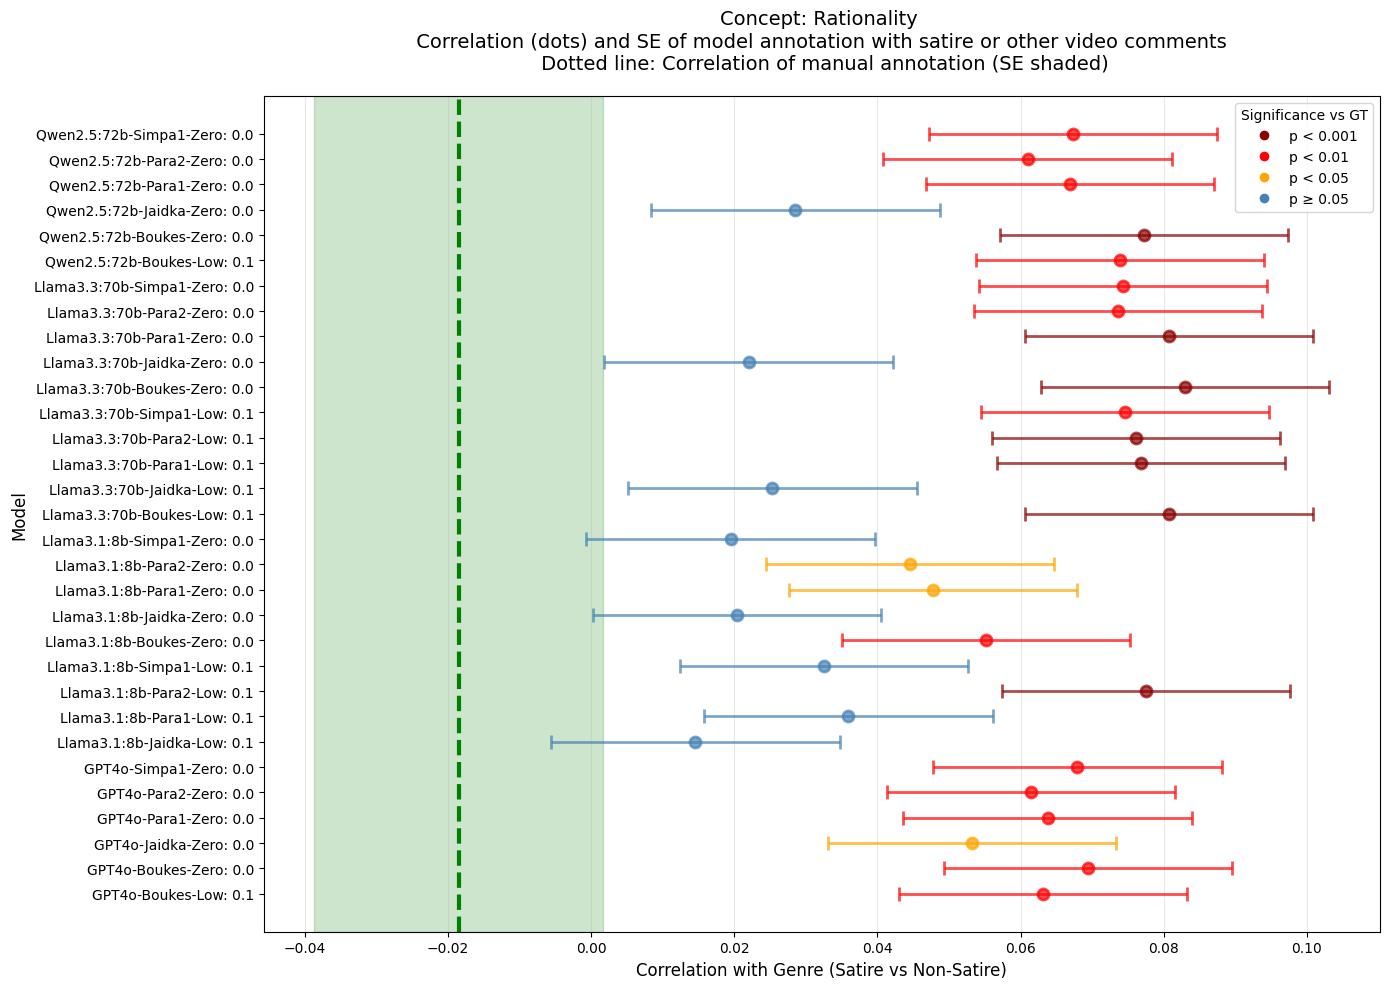

\nCreating plot for concept: Interactivity


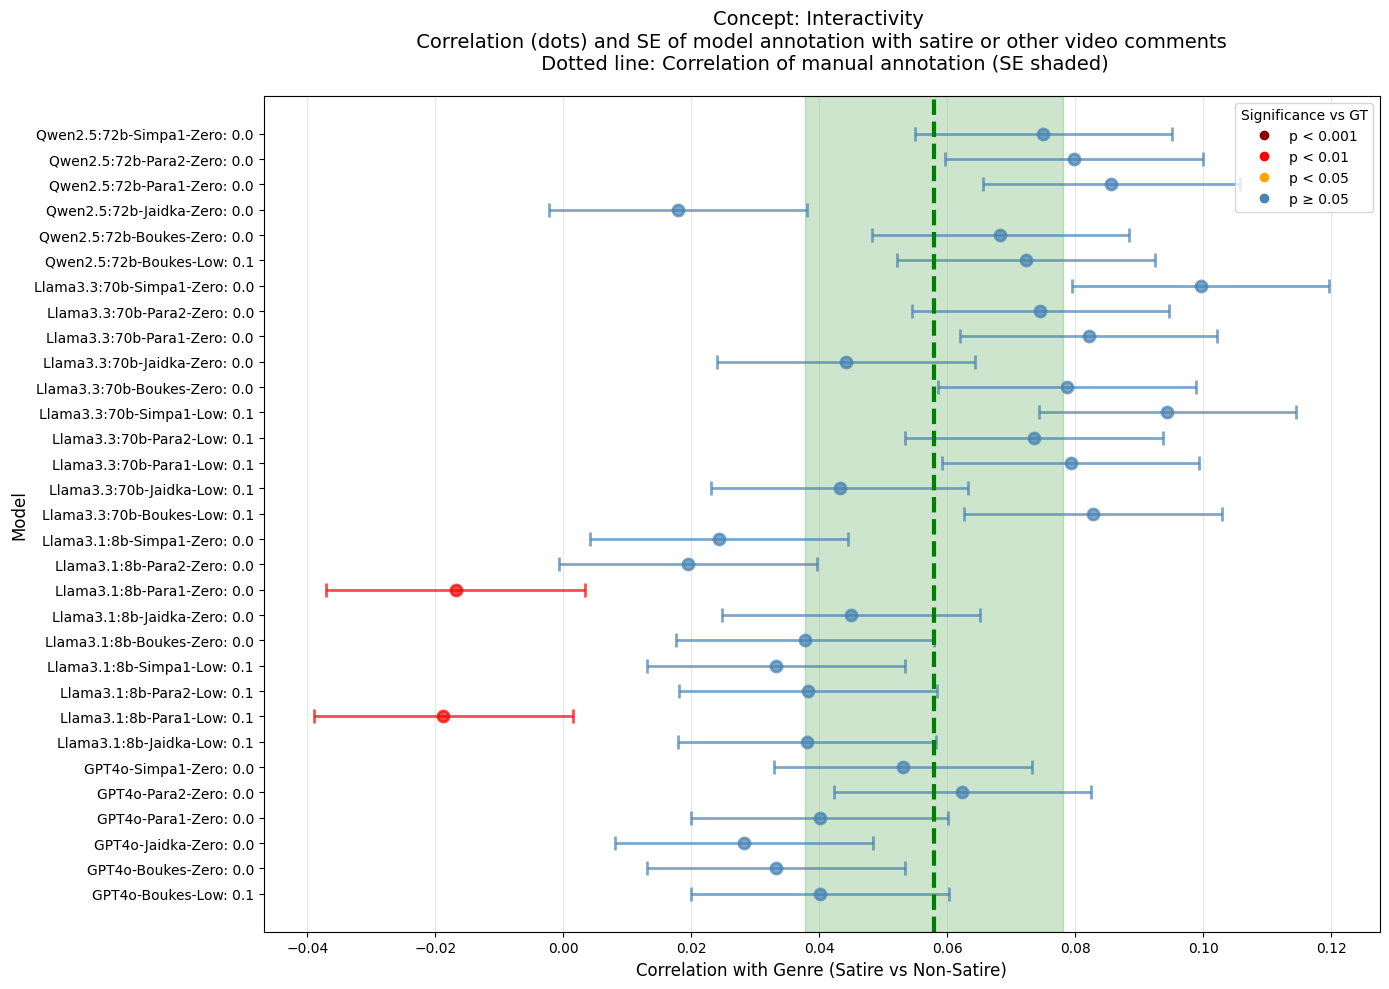

\nCreating plot for concept: Incivility


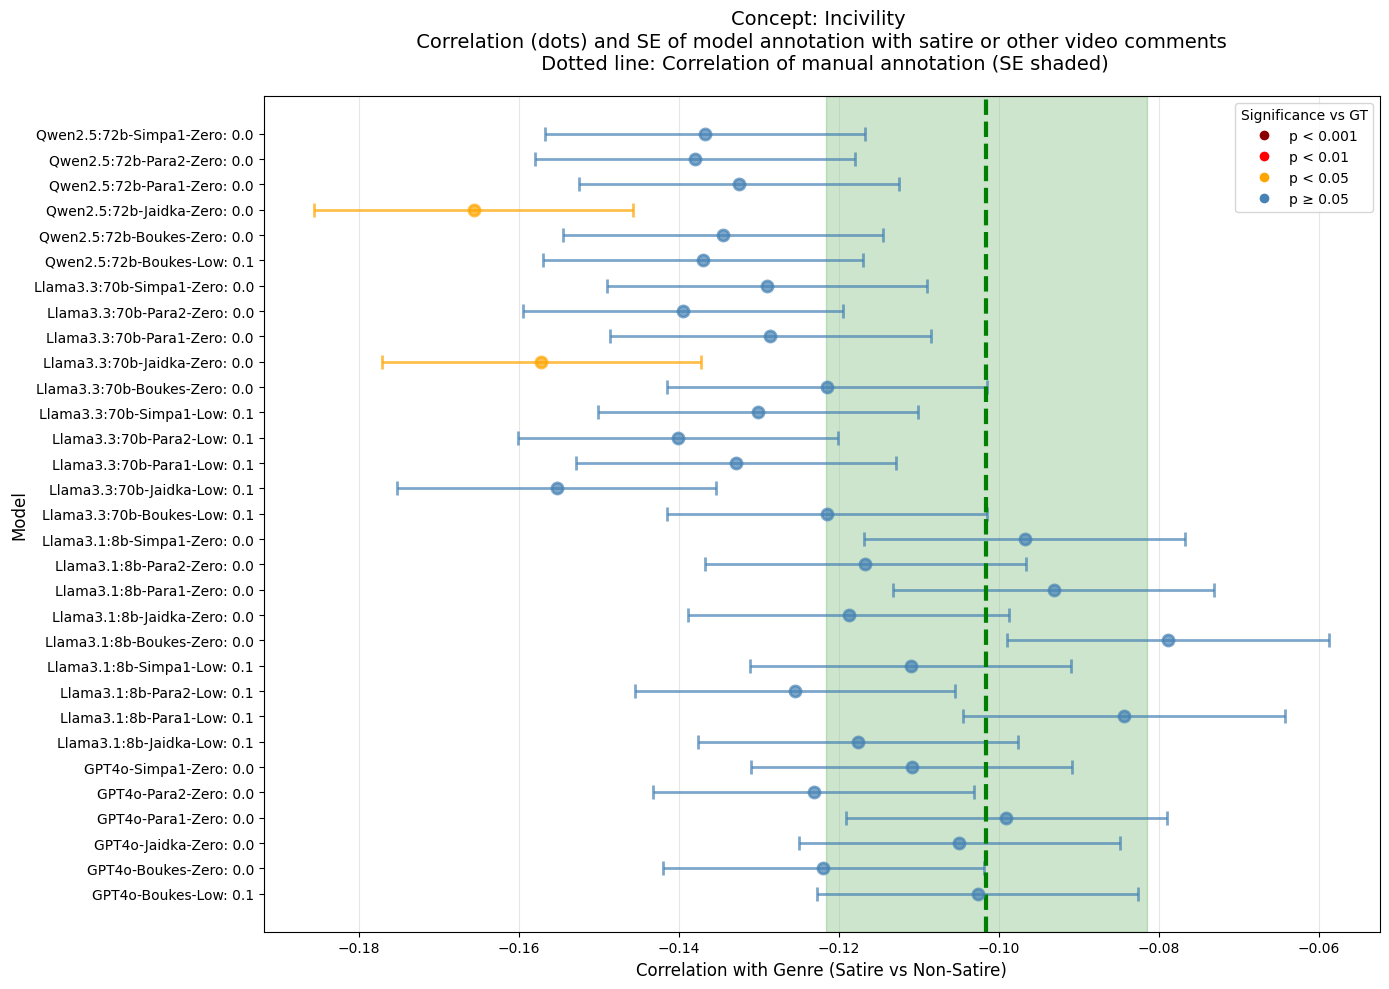

\nCreating plot for concept: Conservative


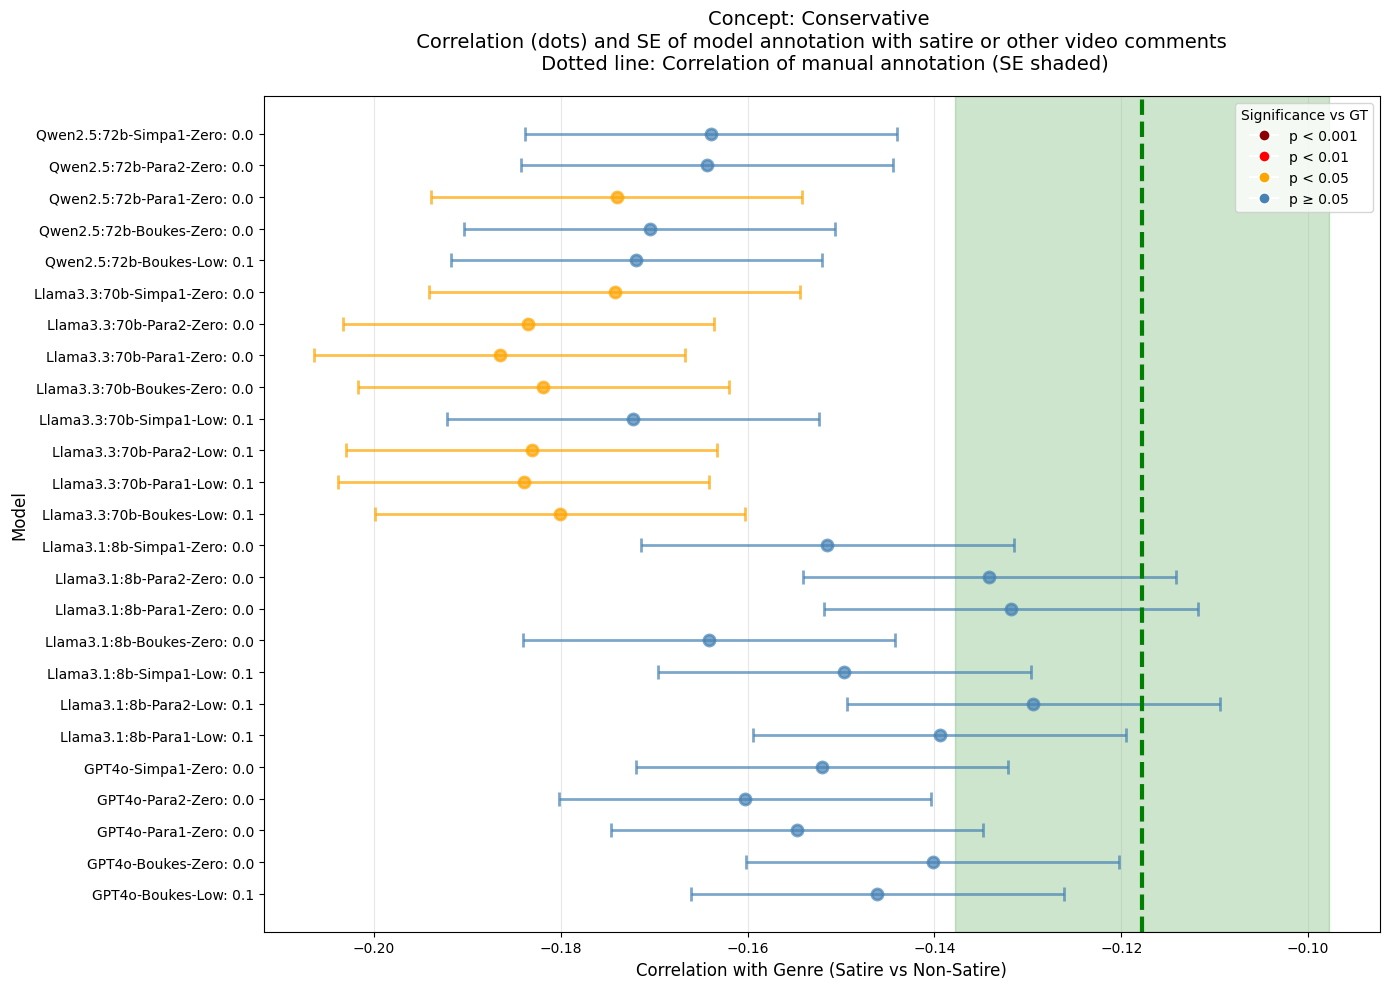

\nCreating plot for concept: Liberal


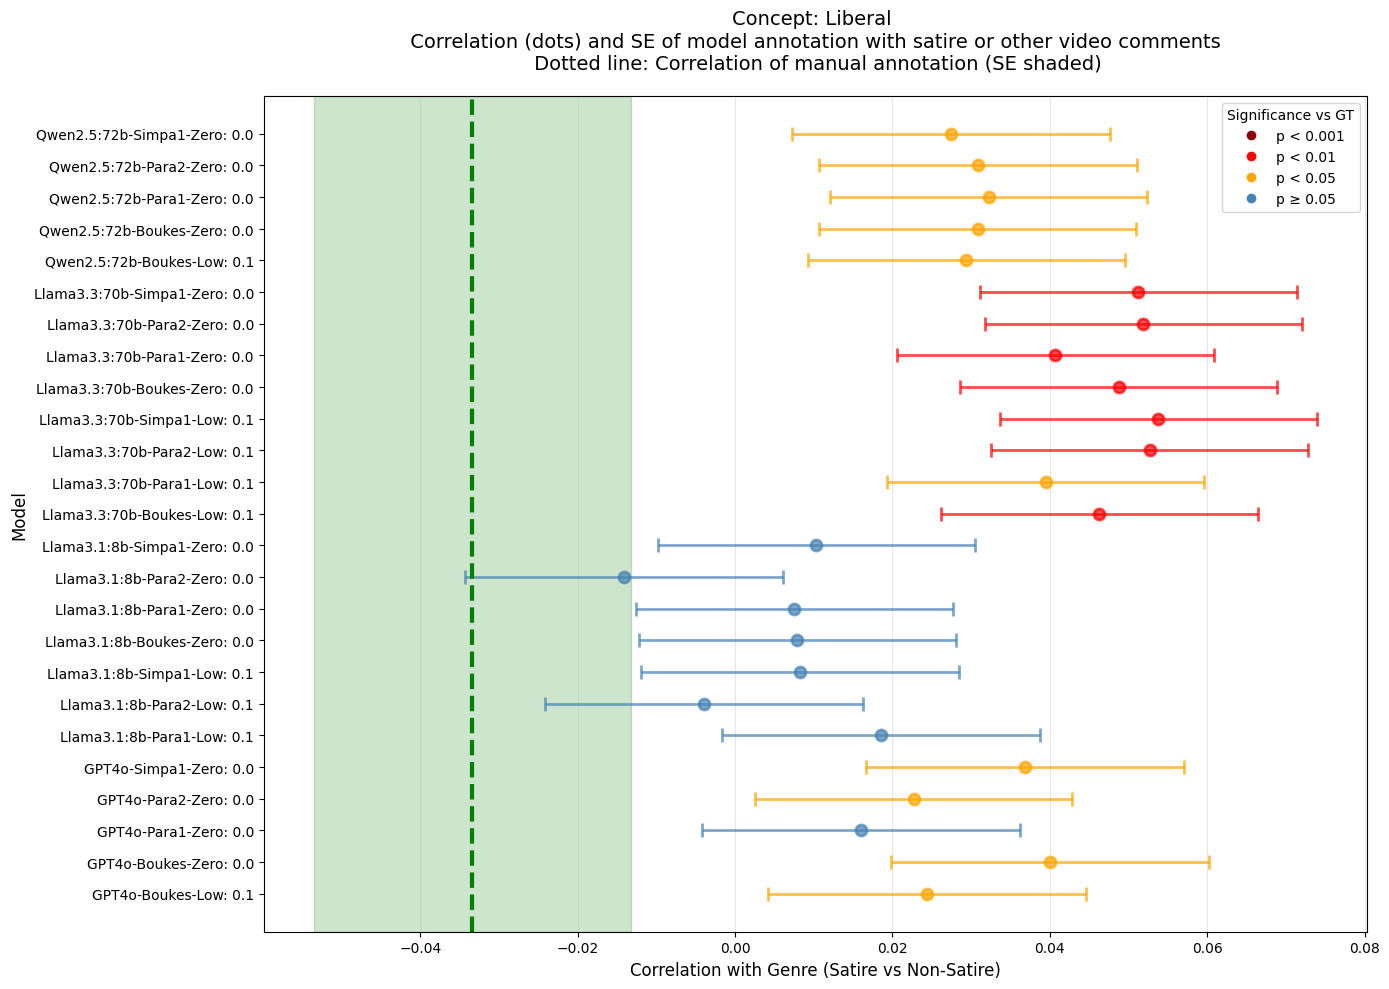

\nCreating plot for concept: Political Post


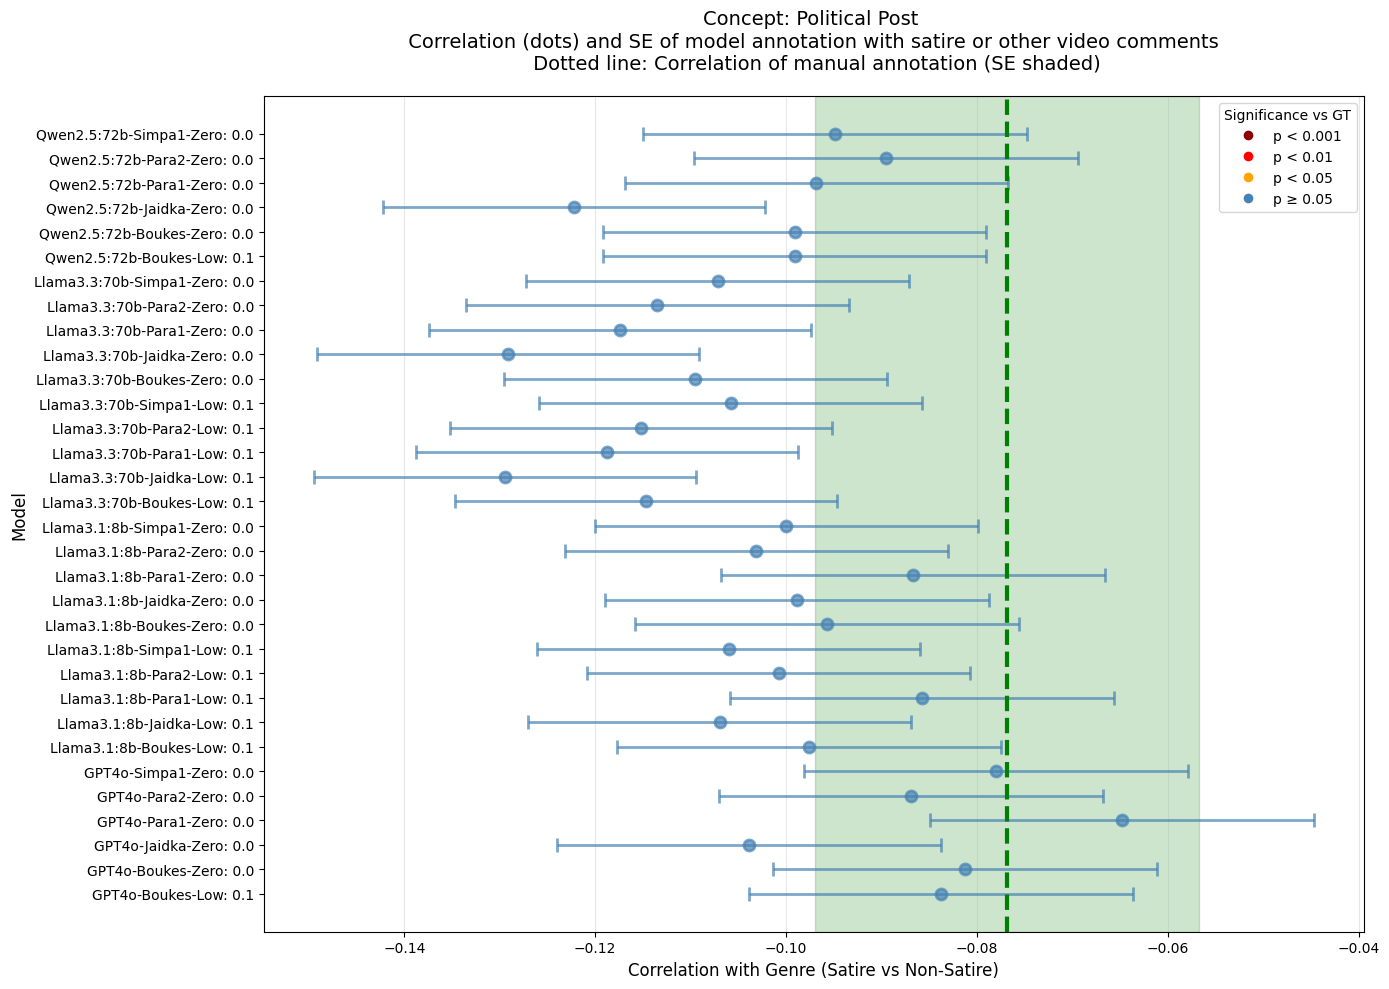

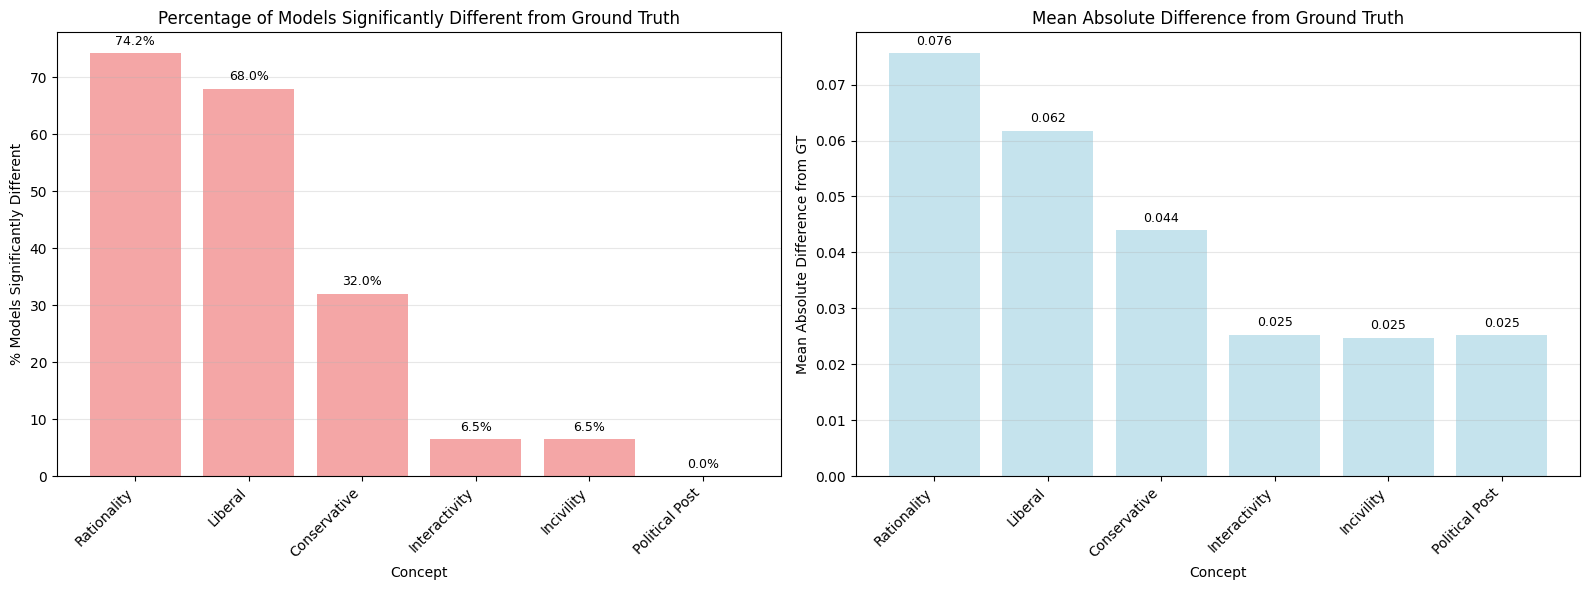

In [23]:
# COMPREHENSIVE VISUALIZATION FOR ALL CONCEPTS
# Create plots showing correlations and significance for all concepts

def create_short_label(model_column):
    """
    Create a shorter, more readable label from model column name.
    Extract model, prompt_variant, and temperature.
    
    Args:
    - model_column: Full model column name
    
    Returns:
    - Shortened label string
    """
    try:
        labels = get_labels(model_column)
        model = labels.get('model', 'unknown')
        prompt_variant = labels.get('prompt_variant', 'unknown')
        temperature = labels.get('temperature', 'unknown')
        
        # Create compact label: Model-PromptVariant-Temperature
        short_label = f"{model}-{prompt_variant}-{temperature}"
        return short_label
    except:
        # Fallback: try to extract key parts from column name
        parts = model_column.split('_')
        if len(parts) >= 3:
            return f"{parts[1]}-{parts[2]}-{parts[-1]}" if len(parts) > 3 else model_column[:20]
        else:
            return model_column[:20]

def get_sorting_key(model_column):
    """
    Extract sorting keys (model, temperature, prompt) from model column name.
    
    Args:
    - model_column: Full model column name
    
    Returns:
    - Tuple of (model, temperature, prompt_variant) for sorting
    """
    try:
        labels = get_labels(model_column)
        model = labels.get('model', 'unknown')
        prompt_variant = labels.get('prompt_variant', 'unknown')
        temperature = labels.get('temperature', 'unknown')
        
        # Convert temperature to numeric for proper sorting if possible
        try:
            temp_numeric = float(temperature) if temperature.replace('.', '').replace('-', '').isdigit() else temperature
        except:
            temp_numeric = temperature
        
        return (model, temp_numeric, prompt_variant)
    except:
        # Fallback: use column name parts
        parts = model_column.split('_')
        if len(parts) >= 3:
            return (parts[1] if len(parts) > 1 else '', parts[-1] if len(parts) > 2 else '', parts[2] if len(parts) > 2 else '')
        else:
            return (model_column, '', '')

def create_concept_correlation_plot(concept_results, figsize=(12, 8)):
    """
    Create a correlation plot for a single concept.
    
    Args:
    - concept_results: Results dictionary from analyze_concept_correlations
    - figsize: Figure size tuple
    
    Returns:
    - Figure and axis objects
    """
    concept = concept_results['concept']
    results_df = concept_results['results_df']
    
    # Separate ground truth and models
    gt_row = results_df[results_df['is_ground_truth']]
    model_rows = results_df[~results_df['is_ground_truth']].copy()
    
    if len(gt_row) == 0 or len(model_rows) == 0:
        return None, None
    
    # Sort model rows by model, temperature, prompt
    model_rows['sort_key'] = model_rows['model_column'].apply(get_sorting_key)
    model_rows = model_rows.sort_values('sort_key').reset_index(drop=True)
    # Remove the temporary sort_key column
    model_rows = model_rows.drop('sort_key', axis=1)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Plot model correlations
    y_positions = range(len(model_rows))
    correlations = model_rows['correlation'].values
    errors = model_rows['se'].values
    
    # Color code by significance if available
    colors = []
    for _, row in model_rows.iterrows():
        model_name = row['model_column']
        # Try to get significance from statistical results
        if concept in all_significance_results:
            sig_df = all_significance_results[concept]
            sig_row = sig_df[sig_df['model_column'] == model_name]
            if len(sig_row) > 0:
                p_val = sig_row['p_value'].iloc[0]
                if p_val < 0.001:
                    colors.append('darkred')
                elif p_val < 0.01:
                    colors.append('red')
                elif p_val < 0.05:
                    colors.append('orange')
                else:
                    colors.append('steelblue')
            else:
                colors.append('steelblue')
        else:
            colors.append('steelblue')
    
    # Create error bars with color coding
    for i, (corr, err, color) in enumerate(zip(correlations, errors, colors)):
        ax.errorbar(corr, y_positions[i], xerr=err, fmt='o', capsize=5, capthick=2, 
                   markersize=8, linewidth=2, color=color, markerfacecolor=color, 
                   markeredgecolor=color, markeredgewidth=2, alpha=0.7)
    
    # Add ground truth reference
    gt_corr = gt_row['correlation'].iloc[0]
    gt_se = gt_row['se'].iloc[0]
    
    # Shaded area for ground truth ±1 SE
    ax.axvspan(gt_corr - gt_se, gt_corr + gt_se, alpha=0.2, color='green', 
               label=f'Ground Truth ±1 SE')
    
    # Ground truth reference line
    ax.axvline(x=gt_corr, color='green', linestyle='--', linewidth=3, 
               label=f'Ground Truth: {gt_corr:.3f}')
    
    # Customize the plot
    ax.set_yticks(y_positions)
    # Use shorter, more readable labels
    short_labels = [create_short_label(name) for name in model_rows['model_column']]
    ax.set_yticklabels(short_labels, fontsize=10)
    ax.set_xlabel(f'Correlation with Genre (Satire vs Non-Satire)', fontsize=12)
    ax.set_ylabel('Model', fontsize=12)
    ax.set_title(f'Concept: {concept} \n Correlation (dots) and SE of model annotation with satire or other video comments \n Dotted line: Correlation of manual annotation (SE shaded)', fontsize=14, pad=20)
    
    # Add grid and legend
    ax.grid(True, alpha=0.3, axis='x')
    ax.legend(loc='best')
    
    # Add significance legend
    legend_elements = [
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='darkred', markersize=8, label='p < 0.001'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='p < 0.01'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=8, label='p < 0.05'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=8, label='p ≥ 0.05')
    ]
    ax.legend(handles=legend_elements, loc='upper right', title='Significance vs GT')
    
    plt.tight_layout()
    return fig, ax

# Create plots for all concepts
print("\n" + "="*80)
print("CREATING CORRELATION PLOTS FOR ALL CONCEPTS")
print("="*80)

if all_concept_results:
    # Filter out concepts with no valid results
    valid_concept_results = {}
    for concept, results in all_concept_results.items():
        results_df = results['results_df']
        gt_row = results_df[results_df['is_ground_truth']]
        model_rows = results_df[~results_df['is_ground_truth']]
        if len(gt_row) > 0 and len(model_rows) > 0:
            valid_concept_results[concept] = results
    
    n_concepts = len(valid_concept_results)
    
    if n_concepts > 0:
        # Create individual detailed plots
        individual_plots = {}
        for concept, concept_results in valid_concept_results.items():
            print(f"\\nCreating plot for concept: {concept}")
            
            # Create individual detailed plot
            fig, ax = create_concept_correlation_plot(concept_results, figsize=(14, 10))
            if fig is not None:
                individual_plots[concept] = (fig, ax)
                plt.show()
    else:
        print("No valid concept results found for plotting.")
    
    # Summary statistics plot
    if 'overall_summary_df' in globals():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Percentage of significant models by concept
        concepts = overall_summary_df['concept']
        pct_sig = overall_summary_df['pct_significant']
        
        bars1 = ax1.bar(range(len(concepts)), pct_sig, color='lightcoral', alpha=0.7)
        ax1.set_xlabel('Concept')
        ax1.set_ylabel('% Models Significantly Different')
        ax1.set_title('Percentage of Models Significantly Different from Ground Truth')
        ax1.set_xticks(range(len(concepts)))
        ax1.set_xticklabels(concepts, rotation=45, ha='right')
        ax1.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for i, bar in enumerate(bars1):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 1,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
        
        # Plot 2: Mean absolute difference by concept
        mean_diff = overall_summary_df['mean_abs_difference']
        
        bars2 = ax2.bar(range(len(concepts)), mean_diff, color='lightblue', alpha=0.7)
        ax2.set_xlabel('Concept')
        ax2.set_ylabel('Mean Absolute Difference from GT')
        ax2.set_title('Mean Absolute Difference from Ground Truth')
        ax2.set_xticks(range(len(concepts)))
        ax2.set_xticklabels(concepts, rotation=45, ha='right')
        ax2.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for i, bar in enumerate(bars2):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                    f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.tight_layout()
        plt.show()
    else:
        print("No overall summary results available for plotting.")
  
    
else:
    print("No concept results available for plotting.")